In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

#### The notebook is divided in 4 parts:
#### Part 1: Exploring the data
#### Part 2: Understanding Customer Base habits/summary
#### Part 3: RFM Analysis
#### Part 4: Clustering using KMeans and customer segmentation

In [2]:
df_customer = pd.read_csv('customers_sample.csv').set_index('customer_number')
df_baskets = pd.read_csv('baskets_sample.csv').set_index('customer_number')
df_category_spends = pd.read_csv('category_spends_sample.csv').set_index('customer_number')
df_lineitems = pd.read_csv('lineitems_sample.csv').set_index('customer_number')

#### Cleaning data:

In [3]:
df_customer[df_customer.columns[3]]= df_customer[df_customer.columns[3]].replace('[\£,]', '', regex=True).astype(float)
df_customer[df_customer.columns[4]]= df_customer[df_customer.columns[4]].replace('[\£,]', '', regex=True).astype(float)
df_customer.head(2)

,baskets,total_quantity,average_quantity,total_spend,average_spend
customer_number,,,,,
4749,220,260,1.181818,631.12,2.87
4757,248,333,1.342742,452.42,1.82


In [4]:
df_baskets[df_baskets.columns[2]]= df_baskets[df_baskets.columns[2]].replace('[\£,]', '', regex=True).astype(float)
df_baskets.head(2)

,purchase_time,basket_quantity,basket_spend,basket_categories
customer_number,,,,
11911,2007-03-01 07:06:00,7,3.09,3
4047,2007-03-01 07:13:00,9,7.99,5


In [5]:
df_category_spends= df_category_spends.replace('[\£,]', '', regex=True).astype(float)
df_category_spends.head(2)

,fruit_veg,dairy,confectionary,grocery_food,grocery_health_pets,bakery,newspapers_magazines,prepared_meals,soft_drinks,frozen,meat,tobacco,drinks,deli,world_foods,lottery,cashpoint,seasonal_gifting,discount_bakery,practical_items
customer_number,,,,,,,,,,,,,,,,,,,,
11387,64.58,35.91,107.78,27.08,29.59,0.0,54.83,6.35,22.83,21.51,28.62,162.1,28.02,28.12,28.54,2.0,15.0,7.48,0.0,0.84
8171,16.89,37.24,28.84,33.43,66.40,0.0,22.06,12.09,2.34,78.74,26.44,0.0,8.42,2.65,3.76,0.0,0.0,9.99,0.0,0.00


In [6]:
df_lineitems[df_lineitems.columns[4]]= df_lineitems[df_lineitems.columns[4]].replace('[\£,]', '', regex=True).astype(float)
df_lineitems.head(2)

,purchase_time,product_id,category,quantity,spend
customer_number,,,,,
14577,2007-03-10 11:58:00,722653,GROCERY_FOOD,1,1.39
7210,2007-03-22 10:53:00,696136,GROCERY_HEALTH_PETS,1,4.25


# Part 1 : Exploring the data:

### 1. Customers table

In [7]:
df_customer.head(2)

,baskets,total_quantity,average_quantity,total_spend,average_spend
customer_number,,,,,
4749,220,260,1.181818,631.12,2.87
4757,248,333,1.342742,452.42,1.82


In [8]:
df_customer.shape

(3000, 5)

In [9]:
# Null check
df_customer.isna().sum()

baskets             0
total_quantity      0
average_quantity    0
total_spend         0
average_spend       0
dtype: int64

#### There are no null values here.

In [10]:
df_customer.describe()

,baskets,total_quantity,average_quantity,total_spend,average_spend
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,487.105000,583.722000,1.204499,769.412937,1.682477
std,332.824524,405.006359,0.136323,552.769022,0.733105
min,6.000000,6.000000,1.000000,7.280000,0.620000
25%,257.000000,307.750000,1.119625,406.120000,1.260000
50%,417.000000,495.000000,1.175889,627.170000,1.490000
75%,628.250000,744.250000,1.250430,957.675000,1.860000
max,3119.000000,4949.000000,2.503686,6588.650000,10.840000


The mean total_spend is 769.412937 while average spend per quantity is 1.682477. The average quantity bought is around 583.

In [11]:
(df_customer < 0).any() #checking negative values

baskets             False
total_quantity      False
average_quantity    False
total_spend         False
average_spend       False
dtype: bool

There are no negative values here.

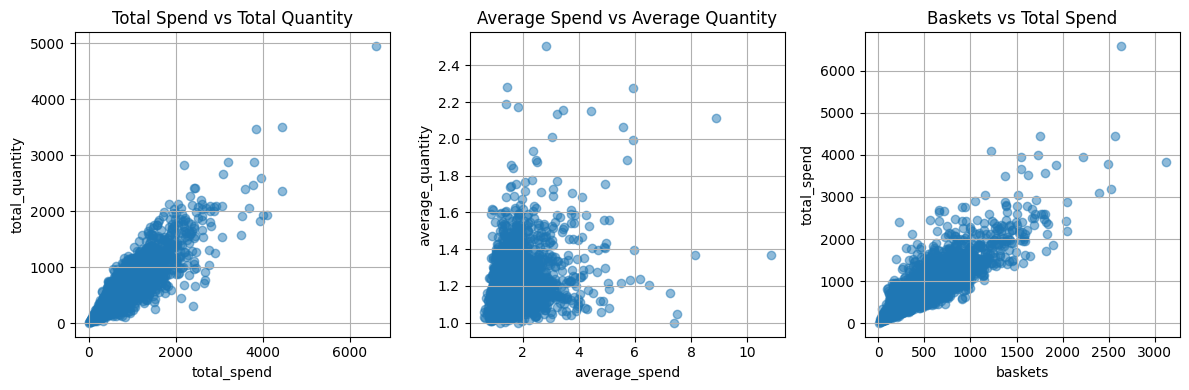

In [12]:
plots = {
    'Total Spend vs Total Quantity': ('total_spend', 'total_quantity'),
    'Average Spend vs Average Quantity': ('average_spend', 'average_quantity'),
    'Baskets vs Total Spend': ('baskets', 'total_spend')
}

# Plotting the graphs using subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

for ax, (title, (x_col, y_col)) in zip(axes, plots.items()):
    ax.scatter(df_customer[x_col], df_customer[y_col], alpha=0.5)
    ax.set_title(title)
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    ax.grid(True)

plt.tight_layout()
plt.show()

It is observed here that- customers who spend more also tend to purchase larger quantities of items. And also who visit more (no. of baskets tell frequency of visits) tend to spend higher. 

### 2. Baskets table

In [13]:
df_baskets.head(2)

,purchase_time,basket_quantity,basket_spend,basket_categories
customer_number,,,,
11911,2007-03-01 07:06:00,7,3.09,3
4047,2007-03-01 07:13:00,9,7.99,5


In [14]:
df_baskets.shape

(195547, 4)

In [15]:
#Checking null values
df_baskets.isna().sum()

purchase_time        0
basket_quantity      0
basket_spend         0
basket_categories    0
dtype: int64

In [16]:
#checking for negative values
records_with_negative_spend = df_baskets[df_baskets['basket_spend'] < 0]
records_with_negative_qty = df_baskets[df_baskets['basket_quantity'] < 0]

In [17]:
records_with_negative_spend.shape

(160, 4)

In [18]:
records_with_negative_qty.shape

(19, 4)

Here as well, the negative values for basket_spend and basket_quantity can indicate the amount returned by the store to the customers when the customer returns the product.

In [19]:
df_baskets.describe()

,basket_quantity,basket_spend,basket_categories
count,195547.000000,195547.000000,195547.000000
mean,8.955218,11.804010,4.231990
std,9.510890,13.031542,2.478016
min,-11.000000,-98.400000,1.000000
25%,3.000000,4.280000,2.000000
50%,6.000000,8.130000,4.000000
75%,11.000000,14.480000,6.000000
max,190.000000,377.280000,16.000000


### 3. Category spends table

In [20]:
df_category_spends.head(2)

,fruit_veg,dairy,confectionary,grocery_food,grocery_health_pets,bakery,newspapers_magazines,prepared_meals,soft_drinks,frozen,meat,tobacco,drinks,deli,world_foods,lottery,cashpoint,seasonal_gifting,discount_bakery,practical_items
customer_number,,,,,,,,,,,,,,,,,,,,
11387,64.58,35.91,107.78,27.08,29.59,0.0,54.83,6.35,22.83,21.51,28.62,162.1,28.02,28.12,28.54,2.0,15.0,7.48,0.0,0.84
8171,16.89,37.24,28.84,33.43,66.40,0.0,22.06,12.09,2.34,78.74,26.44,0.0,8.42,2.65,3.76,0.0,0.0,9.99,0.0,0.00


In [21]:
df_category_spends.shape

(3000, 20)

In [22]:
(df_category_spends < 0).any()

fruit_veg               False
dairy                   False
confectionary           False
grocery_food            False
grocery_health_pets     False
bakery                  False
newspapers_magazines    False
prepared_meals          False
soft_drinks             False
frozen                  False
meat                    False
tobacco                 False
drinks                  False
deli                    False
world_foods             False
lottery                  True
cashpoint               False
seasonal_gifting        False
discount_bakery         False
practical_items         False
dtype: bool

From above, we see, only lottery has negative spending value.

In [23]:
df_category_spends.isna().sum()

fruit_veg               0
dairy                   0
confectionary           0
grocery_food            0
grocery_health_pets     0
bakery                  0
newspapers_magazines    0
prepared_meals          0
soft_drinks             0
frozen                  0
meat                    0
tobacco                 0
drinks                  0
deli                    0
world_foods             0
lottery                 0
cashpoint               0
seasonal_gifting        0
discount_bakery         0
practical_items         0
dtype: int64

In [24]:
df_category_spends.describe()

,fruit_veg,dairy,confectionary,grocery_food,grocery_health_pets,bakery,newspapers_magazines,prepared_meals,soft_drinks,frozen,meat,tobacco,drinks,deli,world_foods,lottery,cashpoint,seasonal_gifting,discount_bakery,practical_items
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.0,3000.000000,3000.00000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,69.456163,71.302683,57.347793,60.007530,60.909867,0.0,16.653390,35.48057,23.303350,35.466020,54.740687,92.547613,62.242217,13.736440,8.554260,14.165603,45.330583,6.126987,1.814837,2.016220
std,70.499654,57.966265,55.959350,57.682533,69.805023,0.0,26.377091,41.24047,35.695592,41.477609,67.802126,201.703812,121.500365,25.486136,14.757745,48.469754,123.584361,13.104271,9.450367,4.322232
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-74.000000,0.000000,0.000000,0.000000,0.000000
25%,22.695000,31.390000,21.070000,21.087500,18.145000,0.0,1.500000,8.70000,3.750000,8.777500,12.640000,0.000000,0.000000,0.000000,0.890000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,50.935000,56.875000,42.290000,44.030000,39.075000,0.0,7.345000,23.09500,11.685000,22.275000,32.930000,2.030000,12.830000,3.495000,3.760000,0.000000,0.000000,1.990000,0.000000,0.000000
75%,93.405000,95.327500,75.125000,80.922500,77.250000,0.0,19.687500,47.33000,28.782500,47.237500,72.380000,81.030000,65.150000,15.770000,10.647500,6.000000,30.000000,6.720000,0.000000,2.510000
max,1262.970000,708.040000,614.370000,1017.070000,884.450000,0.0,351.730000,454.29000,529.650000,385.800000,713.280000,2488.940000,1005.330000,316.190000,321.490000,946.000000,2137.010000,229.440000,173.060000,65.060000


In [25]:
sum_bakery_spends_category_table = df_category_spends['bakery'].sum()
sum_bakery_spends_category_table

0.0

In [26]:
lineitems_sample_spend_exploration= df_lineitems.groupby(['customer_number','category'])['spend'].sum().unstack('category', fill_value=0).add_prefix('SPEND_ON_')
lineitems_sample_spend_exploration.reset_index()
lineitems_sample_spend_exploration.head()

category,SPEND_ON_BAKERY,SPEND_ON_CASHPOINT,SPEND_ON_CONFECTIONARY,SPEND_ON_DAIRY,SPEND_ON_DELI,SPEND_ON_DISCOUNT_BAKERY,SPEND_ON_DRINKS,SPEND_ON_FROZEN,SPEND_ON_FRUIT_VEG,SPEND_ON_GROCERY_FOOD,SPEND_ON_GROCERY_HEALTH_PETS,SPEND_ON_LOTTERY,SPEND_ON_MEAT,SPEND_ON_NEWSPAPERS_MAGAZINES,SPEND_ON_PRACTICAL_ITEMS,SPEND_ON_PREPARED_MEALS,SPEND_ON_SEASONAL_GIFTING,SPEND_ON_SOFT_DRINKS,SPEND_ON_TOBACCO,SPEND_ON_WORLD_FOODS
customer_number,,,,,,,,,,,,,,,,,,,,
14,18.09,0.0,23.22,172.58,0.00,1.25,113.45,25.29,11.10,56.05,11.28,0.0,182.37,6.40,0.00,23.36,5.07,5.31,0.0,20.90
45,18.00,0.0,106.54,142.16,2.00,0.00,0.00,7.05,30.21,83.42,24.31,0.0,60.31,17.49,0.00,56.51,0.00,29.65,0.0,8.08
52,2.45,10.0,3.29,5.19,49.07,0.00,0.00,1.78,53.29,1.08,12.11,1.0,9.74,3.12,0.00,2.78,23.20,8.98,0.0,35.10
61,32.75,0.0,46.39,55.29,19.88,0.00,20.65,18.63,70.18,56.18,45.71,6.0,121.38,5.55,2.87,12.12,3.04,14.87,0.0,16.38
63,33.35,0.0,73.07,42.11,32.14,0.00,0.00,14.53,22.01,13.54,25.08,3.0,3.46,2.00,0.00,13.38,0.00,1.67,0.0,14.00


In [27]:
sum_bakery_spends_lineitems_table = lineitems_sample_spend_exploration['SPEND_ON_BAKERY'].sum()
sum_bakery_spends_lineitems_table

114630.37

Thus, we see there is some inconsistency in the category spends table for bakery column where all the values are set to '0', however, when aggregated through the lineitems table, we see the values for bakery spends

### 4. lineitems table

In [28]:
df_lineitems.head(2)

,purchase_time,product_id,category,quantity,spend
customer_number,,,,,
14577,2007-03-10 11:58:00,722653,GROCERY_FOOD,1,1.39
7210,2007-03-22 10:53:00,696136,GROCERY_HEALTH_PETS,1,4.25


In [29]:
df_lineitems.shape

(1461315, 5)

In [30]:
# Null check
df_lineitems.isna().sum()

purchase_time    0
product_id       0
category         0
quantity         0
spend            0
dtype: int64

#### There are no null values here.

In [31]:
records_with_negative_spend = df_lineitems[df_lineitems['spend'] < 0]
records_with_negative_qty = df_lineitems[df_lineitems['quantity'] < 0]

In [32]:
records_with_negative_spend.shape

(864, 5)

In [33]:
records_with_negative_qty.shape

(864, 5)

In [34]:
# Filter the DataFrame for spend less than 0
negative_spend_categories = df_lineitems.loc[df_lineitems['spend'] < 0, 'category']
negative_quantity_categories = df_lineitems.loc[df_lineitems['quantity'] < 0, 'category']

# Print the list of categories with spend & quantity less than 0
print("Categories with spend less than 0:")
print(negative_spend_categories.unique())

print("Categories with spend less than 0:")
print(negative_quantity_categories.unique())

Categories with spend less than 0:
['LOTTERY' 'GROCERY_HEALTH_PETS' 'SOFT_DRINKS' 'DRINKS' 'CONFECTIONARY'
 'DELI' 'MEAT']
Categories with spend less than 0:
['LOTTERY' 'GROCERY_HEALTH_PETS' 'SOFT_DRINKS' 'DRINKS' 'CONFECTIONARY'
 'DELI' 'MEAT']


#### There are total 864 records with negative spend and qty values and all those records belong to categories- ['LOTTERY' 'GROCERY_HEALTH_PETS' 'SOFT_DRINKS' 'DRINKS' 'CONFECTIONARY''DELI' 'MEAT'] 
#### The negative values in the dataset for spend and quantity can indicate amount returned by the store to the customers when customer returns the product.

In [35]:
df_lineitems.columns

Index(['purchase_time', 'product_id', 'category', 'quantity', 'spend'], dtype='object')

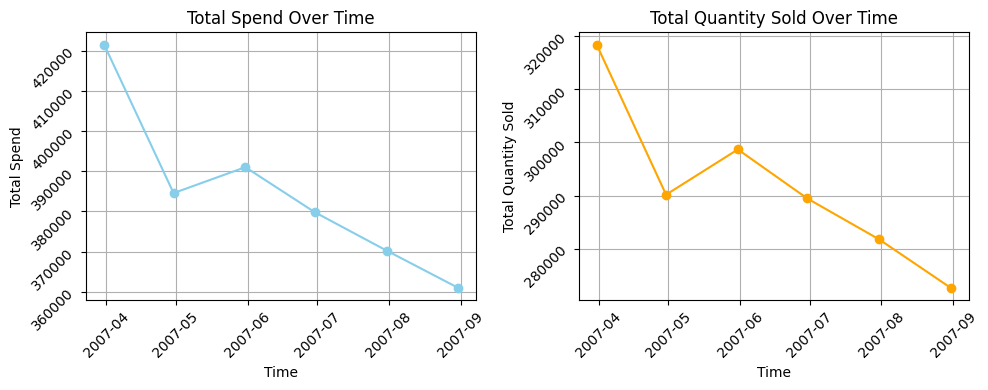

In [36]:
df_lineitems['purchase_time'] = pd.to_datetime(df_lineitems['purchase_time'])

# Extract date from purchase_time
df_lineitems['purchase_date'] = df_lineitems['purchase_time'].dt.date

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

# Plot total spend over time
total_spend_over_time = df_lineitems.groupby(pd.Grouper(key='purchase_time', freq='M'))['spend'].sum()
axes[0].plot(total_spend_over_time.index, total_spend_over_time.values, marker='o', color='skyblue', linestyle='-')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Total Spend')
axes[0].set_title('Total Spend Over Time')
axes[0].grid(True)
axes[0].tick_params(rotation=45)

# Plot total quantity sold over time
total_quantity_over_time = df_lineitems.groupby(pd.Grouper(key='purchase_time', freq='M'))['quantity'].sum()
axes[1].plot(total_quantity_over_time.index, total_quantity_over_time.values, marker='o', color='orange', linestyle='-')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Total Quantity Sold')
axes[1].set_title('Total Quantity Sold Over Time')
axes[1].grid(True)
axes[1].tick_params(rotation=45)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

In [37]:
print('Unique categories:', df_lineitems.category.nunique())
print('Unique products:', df_lineitems.product_id.nunique())

Unique categories: 20
Unique products: 20466


### **** Feature Importance Analysis ****

In [38]:
# Grouping lineitems table
lineitems_sample_quantity_exploration= df_lineitems.groupby(['customer_number','category'])['quantity'].sum().unstack('category', fill_value=0).add_prefix('QUANTITY_')
lineitems_sample_quantity_exploration.reset_index()

lineitems_sample_quantity_exploration.head()

category,QUANTITY_BAKERY,QUANTITY_CASHPOINT,QUANTITY_CONFECTIONARY,QUANTITY_DAIRY,QUANTITY_DELI,QUANTITY_DISCOUNT_BAKERY,QUANTITY_DRINKS,QUANTITY_FROZEN,QUANTITY_FRUIT_VEG,QUANTITY_GROCERY_FOOD,QUANTITY_GROCERY_HEALTH_PETS,QUANTITY_LOTTERY,QUANTITY_MEAT,QUANTITY_NEWSPAPERS_MAGAZINES,QUANTITY_PRACTICAL_ITEMS,QUANTITY_PREPARED_MEALS,QUANTITY_SEASONAL_GIFTING,QUANTITY_SOFT_DRINKS,QUANTITY_TOBACCO,QUANTITY_WORLD_FOODS
customer_number,,,,,,,,,,,,,,,,,,,,
14,29,0,28,133,0,1,69,14,18,57,44,0,69,2,0,10,4,17,0,36
45,23,0,126,183,1,0,0,5,27,108,25,0,33,41,0,35,0,38,0,10
52,5,1,10,9,30,0,0,1,54,1,9,1,6,3,0,2,7,18,0,137
61,49,0,81,52,16,0,4,9,59,72,27,1,64,10,3,8,3,19,0,22
63,40,0,71,42,17,0,0,11,21,15,25,3,2,3,0,12,0,3,0,16


In [39]:
category_spend_quantity_exploration= df_category_spends.merge(lineitems_sample_quantity_exploration, how= 'inner', left_index=True, right_index=True)
category_spend_quantity_customers_exploration= category_spend_quantity_exploration.merge(df_customer, how= 'inner', left_index=True, right_index=True)
baskets_sample_sum_exploration = df_baskets.groupby('customer_number')[['basket_quantity', 'basket_spend', 'basket_categories']].sum().add_prefix('SUM_')
baskets_sample_sum_exploration.head(2)

,SUM_basket_quantity,SUM_basket_spend,SUM_basket_categories
customer_number,,,
14,531,675.72,250
45,655,585.73,211


In [40]:
# Now we can join the category_spend_quantity
customers_baskets_categories_lines_exploration= baskets_sample_sum_exploration.merge(category_spend_quantity_customers_exploration, how= 'inner', left_index=True, right_index=True)
customers_baskets_categories_lines_exploration.head(2)

,SUM_basket_quantity,SUM_basket_spend,SUM_basket_categories,fruit_veg,dairy,confectionary,grocery_food,grocery_health_pets,bakery,newspapers_magazines,...,QUANTITY_PREPARED_MEALS,QUANTITY_SEASONAL_GIFTING,QUANTITY_SOFT_DRINKS,QUANTITY_TOBACCO,QUANTITY_WORLD_FOODS,baskets,total_quantity,average_quantity,total_spend,average_spend
customer_number,,,,,,,,,,,,,,,,,,,,,
14,531,675.72,250,11.10,172.58,23.22,56.05,11.28,0.0,6.40,...,10,4,17,0,36,381,531,1.393701,675.72,1.77
45,655,585.73,211,30.21,142.16,106.54,83.42,24.31,0.0,17.49,...,35,0,38,0,10,561,655,1.167558,585.73,1.04


Here, SUM_basket_quantity = total_quantity column and SUM_basket_spend = total_spend column, thus, we will drop SUM_basket_quantity and SUM_basket_spend columns

In [41]:
customers_baskets_categories_lines_exploration.drop(columns =['SUM_basket_spend','SUM_basket_quantity'], inplace =True)
customers_baskets_categories_lines_exploration.shape

(3000, 46)

In [42]:
kmeans = KMeans(n_clusters=6)  
kmeans.fit(customers_baskets_categories_lines_exploration)
clusters = kmeans.labels_

# Analyze cluster characteristics
cluster_centers = kmeans.cluster_centers_

#  Store cluster centroids in a numpy array
cluster_centroids = np.array(cluster_centers)

# Features from customers_baskets_categories_lines_exploration data
features = ['SUM_basket_categories', 'fruit_veg', 'dairy', 'confectionary',
       'grocery_food', 'grocery_health_pets', 'bakery', 'newspapers_magazines',
       'prepared_meals', 'soft_drinks', 'frozen', 'meat', 'tobacco', 'drinks',
       'deli', 'world_foods', 'lottery', 'cashpoint', 'seasonal_gifting',
       'discount_bakery', 'practical_items', 'QUANTITY_BAKERY',
       'QUANTITY_CASHPOINT', 'QUANTITY_CONFECTIONARY', 'QUANTITY_DAIRY',
       'QUANTITY_DELI', 'QUANTITY_DISCOUNT_BAKERY', 'QUANTITY_DRINKS',
       'QUANTITY_FROZEN', 'QUANTITY_FRUIT_VEG', 'QUANTITY_GROCERY_FOOD',
       'QUANTITY_GROCERY_HEALTH_PETS', 'QUANTITY_LOTTERY', 'QUANTITY_MEAT',
       'QUANTITY_NEWSPAPERS_MAGAZINES', 'QUANTITY_PRACTICAL_ITEMS',
       'QUANTITY_PREPARED_MEALS', 'QUANTITY_SEASONAL_GIFTING',
       'QUANTITY_SOFT_DRINKS', 'QUANTITY_TOBACCO', 'QUANTITY_WORLD_FOODS',
       'baskets', 'total_quantity', 'average_quantity', 'total_spend',
       'average_spend']

C:\Users\Prajakta\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


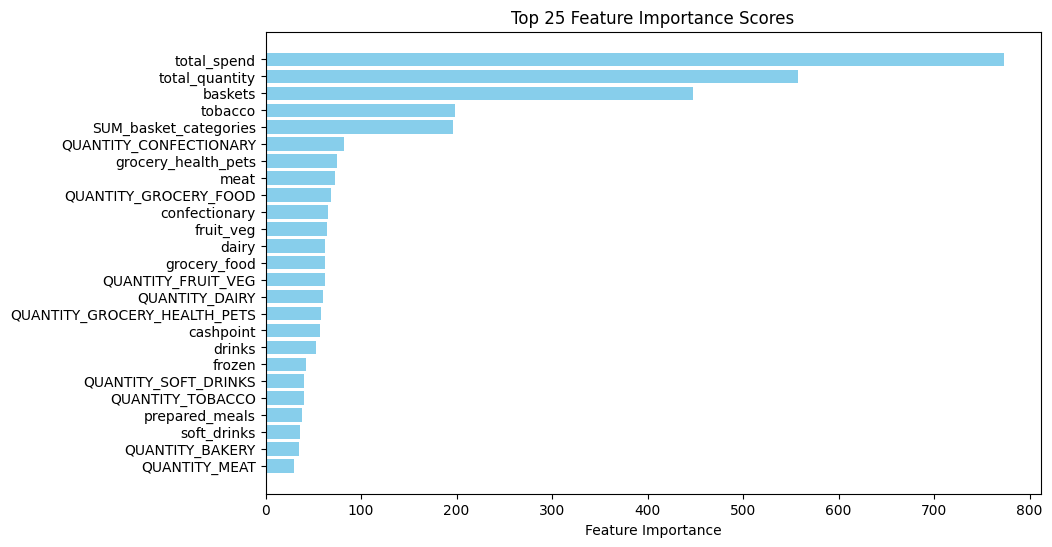

In [43]:
# Calculate mean centroid values across clusters
mean_centroid_values = np.mean(cluster_centroids, axis=0)

# Calculate differences between centroid values of each cluster and the mean
centroid_differences = cluster_centroids - mean_centroid_values

# Analyze feature importance
feature_importance = np.abs(centroid_differences).mean(axis=0)

# Sort features by importance
sorted_features = [feature for _, feature in sorted(zip(feature_importance, features), reverse=True)]

# Print or visualize feature importance
# Sort features by importance
sorted_features_importance = sorted(zip(feature_importance, features), reverse=True)

# Extract top 25 features and their importance values
top_25_features = [feature[1] for feature in sorted_features_importance[:25]]
top_25_importance = [feature[0] for feature in sorted_features_importance[:25]]

# Plotting top 15 feature importance
plt.figure(figsize=(10, 6))
plt.barh(top_25_features, top_25_importance, color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Top 25 Feature Importance Scores')
plt.gca().invert_yaxis()  # Invert y-axis to display highest importance at the top
plt.show()

# Part 2: Understanding Customer Base habits/summary

### Analysing customer habits and trends

### A. Aggregation based on total_spend, num_purchases 

In [44]:
df_lineitems_agg_analysis = df_lineitems.groupby('customer_number').agg({'spend': 'sum', 'purchase_time': 'nunique'}).reset_index()
df_lineitems_agg_analysis.columns = ['customer_number', 'total_spend', 'num_of_unique_visits']
df_lineitems_agg_analysis.head(2)

,customer_number,total_spend,num_of_unique_visits
0,14,675.72,56
1,45,585.73,33


### B. Aggregation based on category

In [45]:
# Create a new dataframe of purchased quantities across product categories
lineitems_sample_quantity_analysis= df_lineitems.groupby(['customer_number','category'])['quantity'].sum().unstack('category', fill_value=0).add_prefix('QUANTITY_')
lineitems_sample_quantity_analysis.reset_index()

# Create a new dataframe of purchased quantities across product categories
lineitems_sample_spend_analysis= df_lineitems.groupby(['customer_number','category'])['spend'].sum().unstack('category', fill_value=0).add_prefix('SPEND_')
lineitems_sample_spend_analysis.reset_index()

lineitems_spend_quantity_analysis = lineitems_sample_spend_analysis.merge(lineitems_sample_quantity_analysis, on='customer_number')
lineitems_spend_quantity_analysis.head()

category,SPEND_BAKERY,SPEND_CASHPOINT,SPEND_CONFECTIONARY,SPEND_DAIRY,SPEND_DELI,SPEND_DISCOUNT_BAKERY,SPEND_DRINKS,SPEND_FROZEN,SPEND_FRUIT_VEG,SPEND_GROCERY_FOOD,...,QUANTITY_GROCERY_HEALTH_PETS,QUANTITY_LOTTERY,QUANTITY_MEAT,QUANTITY_NEWSPAPERS_MAGAZINES,QUANTITY_PRACTICAL_ITEMS,QUANTITY_PREPARED_MEALS,QUANTITY_SEASONAL_GIFTING,QUANTITY_SOFT_DRINKS,QUANTITY_TOBACCO,QUANTITY_WORLD_FOODS
customer_number,,,,,,,,,,,,,,,,,,,,,
14,18.09,0.0,23.22,172.58,0.00,1.25,113.45,25.29,11.10,56.05,...,44,0,69,2,0,10,4,17,0,36
45,18.00,0.0,106.54,142.16,2.00,0.00,0.00,7.05,30.21,83.42,...,25,0,33,41,0,35,0,38,0,10
52,2.45,10.0,3.29,5.19,49.07,0.00,0.00,1.78,53.29,1.08,...,9,1,6,3,0,2,7,18,0,137
61,32.75,0.0,46.39,55.29,19.88,0.00,20.65,18.63,70.18,56.18,...,27,1,64,10,3,8,3,19,0,22
63,33.35,0.0,73.07,42.11,32.14,0.00,0.00,14.53,22.01,13.54,...,25,3,2,3,0,12,0,3,0,16


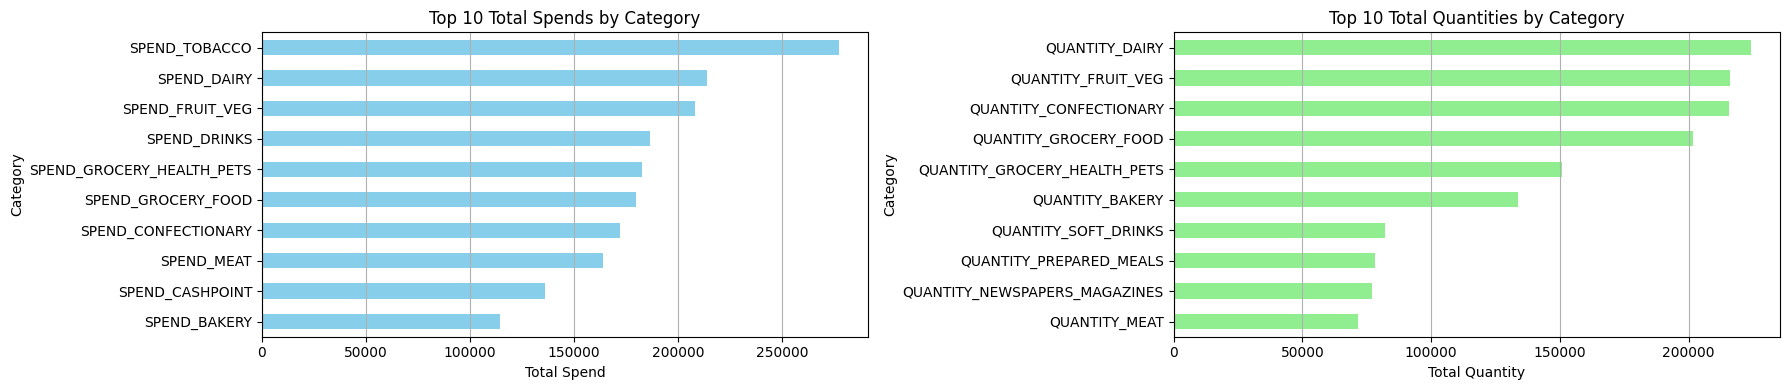

In [46]:
spend_columns = ['SPEND_BAKERY', 'SPEND_CASHPOINT', 'SPEND_CONFECTIONARY', 'SPEND_DAIRY',
       'SPEND_DELI', 'SPEND_DISCOUNT_BAKERY', 'SPEND_DRINKS', 'SPEND_FROZEN',
       'SPEND_FRUIT_VEG', 'SPEND_GROCERY_FOOD', 'SPEND_GROCERY_HEALTH_PETS',
       'SPEND_LOTTERY', 'SPEND_MEAT', 'SPEND_NEWSPAPERS_MAGAZINES',
       'SPEND_PRACTICAL_ITEMS', 'SPEND_PREPARED_MEALS',
       'SPEND_SEASONAL_GIFTING', 'SPEND_SOFT_DRINKS', 'SPEND_TOBACCO',
       'SPEND_WORLD_FOODS']

quantity_columns = ['QUANTITY_BAKERY', 'QUANTITY_CASHPOINT',
       'QUANTITY_CONFECTIONARY', 'QUANTITY_DAIRY', 'QUANTITY_DELI',
       'QUANTITY_DISCOUNT_BAKERY', 'QUANTITY_DRINKS', 'QUANTITY_FROZEN',
       'QUANTITY_FRUIT_VEG', 'QUANTITY_GROCERY_FOOD',
       'QUANTITY_GROCERY_HEALTH_PETS', 'QUANTITY_LOTTERY', 'QUANTITY_MEAT',
       'QUANTITY_NEWSPAPERS_MAGAZINES', 'QUANTITY_PRACTICAL_ITEMS',
       'QUANTITY_PREPARED_MEALS', 'QUANTITY_SEASONAL_GIFTING',
       'QUANTITY_SOFT_DRINKS', 'QUANTITY_TOBACCO', 'QUANTITY_WORLD_FOODS']

# Summing the quantity values across all categories
total_quantities = lineitems_spend_quantity_analysis[quantity_columns].sum()
total_spends = lineitems_spend_quantity_analysis[spend_columns].sum()


# Creating subplots for spend and quantity graphs in one row
fig, axes = plt.subplots(1, 2, figsize=(18, 4))

# Plotting the summed spend values
total_spends.sort_values().tail(10).plot(kind='barh', color='skyblue', ax=axes[0])
axes[0].set_title('Top 10 Total Spends by Category')
axes[0].set_xlabel('Total Spend')
axes[0].set_ylabel('Category')
axes[0].grid(axis='x')

# Plotting the summed quantity values
total_quantities.sort_values().tail(10).plot(kind='barh', color='lightgreen', ax=axes[1])
axes[1].set_title('Top 10 Total Quantities by Category')
axes[1].set_xlabel('Total Quantity')
axes[1].set_ylabel('Category')
axes[1].grid(axis='x')

plt.tight_layout()
plt.show()

### Checking popular product segments

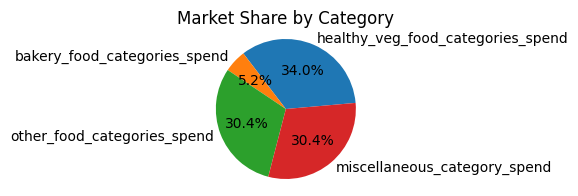

In [47]:
veg_food_categories_spend_analysis = ['SPEND_FRUIT_VEG', 'SPEND_DAIRY', 'SPEND_GROCERY_FOOD', 'SPEND_GROCERY_HEALTH_PETS']
bakery_food_categories_spend_analysis = ['SPEND_BAKERY', 'SPEND_DISCOUNT_BAKERY']
other_food_categories_spend_analysis = ['SPEND_DRINKS', 'SPEND_FROZEN', 'SPEND_DELI', 'SPEND_MEAT', 'SPEND_PREPARED_MEALS', 'SPEND_SOFT_DRINKS', 'SPEND_WORLD_FOODS']
miscellaneous_categories_spend_analysis = ['SPEND_CASHPOINT', 'SPEND_CONFECTIONARY', 'SPEND_LOTTERY', 'SPEND_TOBACCO', 'SPEND_NEWSPAPERS_MAGAZINES', 'SPEND_PRACTICAL_ITEMS', 'SPEND_SEASONAL_GIFTING']

# Aggregate food category quantities
veg_food_category_spending_analysis = lineitems_sample_spend_analysis[veg_food_categories_spend_analysis].sum(axis=1)
bakery_food_categories_spending_analysis = lineitems_sample_spend_analysis[bakery_food_categories_spend_analysis].sum(axis=1)
other_food_category_spending_analysis = lineitems_sample_spend_analysis[other_food_categories_spend_analysis].sum(axis=1)
miscellaneous_category_spending_analysis = lineitems_sample_spend_analysis[miscellaneous_categories_spend_analysis].sum(axis=1)

# Create DataFrame with aggregated category quantities
aggregated_category_spend_analysis = pd.DataFrame({
    'healthy_veg_food_categories_spend': veg_food_category_spending_analysis,
    'bakery_food_categories_spend': bakery_food_categories_spending_analysis,
    'other_food_categories_spend': other_food_category_spending_analysis,
    'miscellaneous_category_spend': miscellaneous_category_spending_analysis
})

# Selecting the spend columns
spend_columns = ['healthy_veg_food_categories_spend', 'bakery_food_categories_spend',
                 'other_food_categories_spend', 'miscellaneous_category_spend']

# Calculating total spend for each category
total_spend_per_category = aggregated_category_spend_analysis[spend_columns].sum()

# Plotting the pie chart
plt.figure(figsize=(4, 2))
plt.pie(total_spend_per_category, labels=total_spend_per_category.index, autopct='%1.1f%%', startangle=5)
plt.title('Market Share by Category')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

# Part 3: RFM Analysis

Using baskets table for RFM Analysis

In [48]:
df_baskets_rfm = df_baskets

In [49]:
df_baskets_rfm['purchase_time']= pd.to_datetime(df_baskets['purchase_time'])
df_baskets_rfm.dtypes

purchase_time        datetime64[ns]
basket_quantity               int64
basket_spend                float64
basket_categories             int64
dtype: object

In [50]:
# Maximum Transaction Date or the latest transaction date.
max_trans_date = max(df_baskets_rfm['purchase_time']).date()
max_trans_date

datetime.date(2007, 8, 31)

In [51]:
import datetime as dt

NOW = dt.datetime(2007,9,1)

rfmTable=df_baskets_rfm.groupby('customer_number').agg({'purchase_time':lambda x:(NOW-x.max()).days,'basket_quantity':lambda x:len(x),'basket_spend':lambda x: x.sum()})
rfmTable.rename(columns={'purchase_time':'Recency','basket_quantity':'Frequency','basket_spend':'monetary_value'},inplace=True)
rfmTable.head()

,Recency,Frequency,monetary_value
customer_number,,,
14,1,56,675.72
45,1,33,585.73
52,2,59,222.18
61,3,37,547.87
63,7,48,293.34


In [52]:
quantiles = rfmTable.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()
quantiles

{'Recency': {0.25: 0.0, 0.5: 2.0, 0.75: 6.0},
 'Frequency': {0.25: 32.0, 0.5: 53.0, 0.75: 86.0},
 'monetary_value': {0.25: 406.12, 0.5: 627.1700000000001, 0.75: 957.675}}

In [53]:
rfmTable.describe()

,Recency,Frequency,monetary_value
count,3000.000000,3000.000000,3000.000000
mean,8.121333,65.182333,769.412937
std,20.938531,47.464717,552.769022
min,0.000000,1.000000,7.280000
25%,0.000000,32.000000,406.120000
50%,2.000000,53.000000,627.170000
75%,6.000000,86.000000,957.675000
max,164.000000,374.000000,6588.650000


In [54]:
def RScore(x,p,quantiles):
    if x<=quantiles[p][0.25]:
        return 4
    elif x<=quantiles[p][0.5]:
        return 3
    elif x<=quantiles[p][0.75]:
        return 2
    else:
        return 1
def FMScore(x,p,quantiles):
    if x<=quantiles[p][0.25]:
        return 1
    elif x<=quantiles[p][0.5]:
        return 2
    elif x<=quantiles[p][0.75]:
        return 3
    else:
        return 4

In [55]:
rfmTable['r_quartile'] = rfmTable['Recency'].apply(RScore, args=('Recency',quantiles,))
rfmTable['f_quartile'] = rfmTable['Frequency'].apply(FMScore, args=('Frequency',quantiles,))
rfmTable['m_quartile'] = rfmTable['monetary_value'].apply(FMScore, args=('monetary_value',quantiles,))

rfmTable['RFMScore']= rfmTable.r_quartile.map(str)+rfmTable.f_quartile.map(str)+rfmTable.m_quartile.map(str)
rfmTable[rfmTable['RFMScore']=='444'].sort_values('monetary_value',ascending=False).head(10)

,Recency,Frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMScore
customer_number,,,,,,,
11475,0,198,4446.80,4,4,4,444
8284,0,261,3992.30,4,4,4,444
11106,0,213,3948.49,4,4,4,444
6248,0,188,3940.75,4,4,4,444
10908,0,136,3843.57,4,4,4,444
10248,0,180,3789.25,4,4,4,444
8152,0,191,3522.19,4,4,4,444
6461,0,277,3491.78,4,4,4,444
11346,0,135,3200.49,4,4,4,444


In [56]:
# Define a function to map RFM score to customer title
def assign_customer_title(score):
    digit_sum = sum(int(digit) for digit in str(score))
    if digit_sum >= 11:
        return 'VVIP Customer'
    elif digit_sum >= 10:
        return 'Platinum Customer'
    elif digit_sum >= 8:
        return 'Loyal'
    elif digit_sum >= 6:
        return 'Need Attention'
    elif digit_sum >= 4:
        return 'At Risk'
    else:
        return 'Lost Customer'

# Apply the function to create the 'customer_title' column
rfmTable['customer_title'] = rfmTable['RFMScore'].apply(assign_customer_title)

# Display the updated segmented_rfm DataFrame
rfmTable.tail()

,Recency,Frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMScore,customer_title
customer_number,,,,,,,,
16295,0,54,679.70,4,3,3,433,Platinum Customer
16301,4,42,251.43,2,2,1,221,At Risk
16303,11,56,354.32,1,3,1,131,At Risk
16306,10,29,462.81,1,1,2,112,At Risk
16316,0,17,330.40,4,1,1,411,Need Attention


### *** RFM Analysis on the data ***

### Recency vs Monetary

<Figure size 500x400 with 0 Axes>

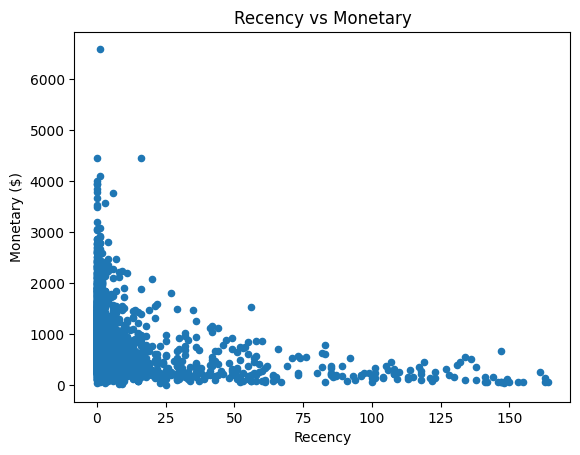

In [57]:
plt.figure(figsize=(5,4))
rfmTable.plot.scatter(x='Recency' , y='monetary_value')
plt.xlabel('Recency')
plt.ylabel('Monetary ($)')
plt.title('Recency vs Monetary')
plt.show()

The graph illustrates that the customers who have low recency between 0-25 days, i.e. who have made the purchase recently have provided more monetary value as compared to people purchasing after a recency of 25 days.

### Frequency vs Monetary

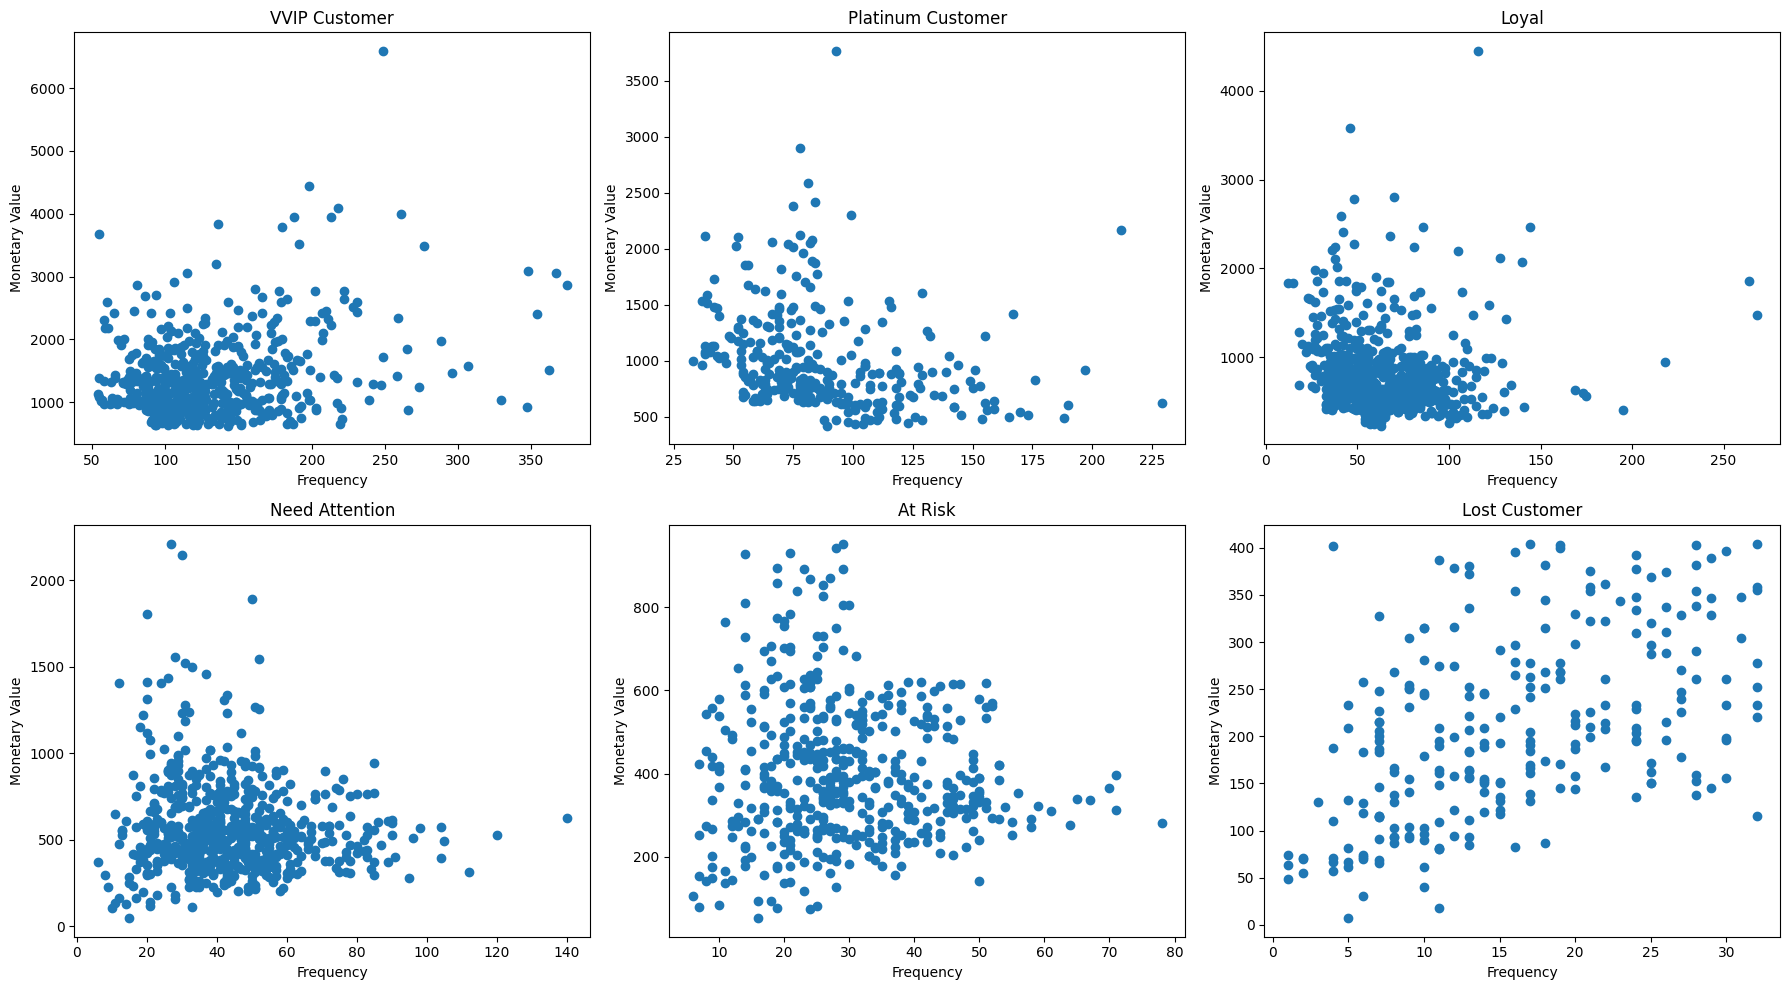

In [58]:
# Define the list of customer titles
customer_titles = ['VVIP Customer','Platinum Customer', 'Loyal', 'Promising', 'Need Attention', 'At Risk', 'Lost Customer']

# Filter out customer titles that are not present in the data
existing_customer_titles = [title for title in customer_titles if title in rfmTable['customer_title'].unique()]

# Calculate the number of subplots needed based on the existing customer titles
num_subplots = len(existing_customer_titles)

# Create a subplot grid based on the number of existing customer titles
num_rows = num_subplots // 4 + (num_subplots % 4 > 0)
fig, axs = plt.subplots(nrows=num_rows, ncols=3, figsize=(18, 5*num_rows))

# Flatten the axs array for easy indexing
axs = axs.flatten()

# Iterate over each customer segment title and plot the corresponding data
for i, title in enumerate(existing_customer_titles):
    # Extract data for the current segment
    segment_data = rfmTable[rfmTable['customer_title'] == title]
    
    # Plot the data
    axs[i].scatter(segment_data['Frequency'], segment_data['monetary_value'])
    axs[i].set_title(title)
    axs[i].set_xlabel('Frequency')
    axs[i].set_ylabel('Monetary Value')

# Hide any remaining empty subplots
for j in range(num_subplots, len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show()

In [59]:
# Calculate average values for each Customer Segment, and return a size of each segment 
rfm_level_agg = rfmTable.groupby('customer_title').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'monetary_value': ['mean', 'count']
}).round(1)
# Print the aggregated dataset
rfm_level_ag = pd.DataFrame(rfm_level_agg)
rfm_level_ag = rfm_level_ag.reset_index()
rfm_level_ag

customer_title Recency Frequency monetary_value      
                        mean      mean           mean count
0            At Risk    13.3      29.7          403.6   477
1      Lost Customer    46.8      16.0          209.6   252
2              Loyal     2.6      64.8          800.8   741
3     Need Attention     5.9      43.6          567.3   665
4  Platinum Customer     0.9      87.5         1011.1   305
5      VVIP Customer     0.2     131.5         1399.8   560

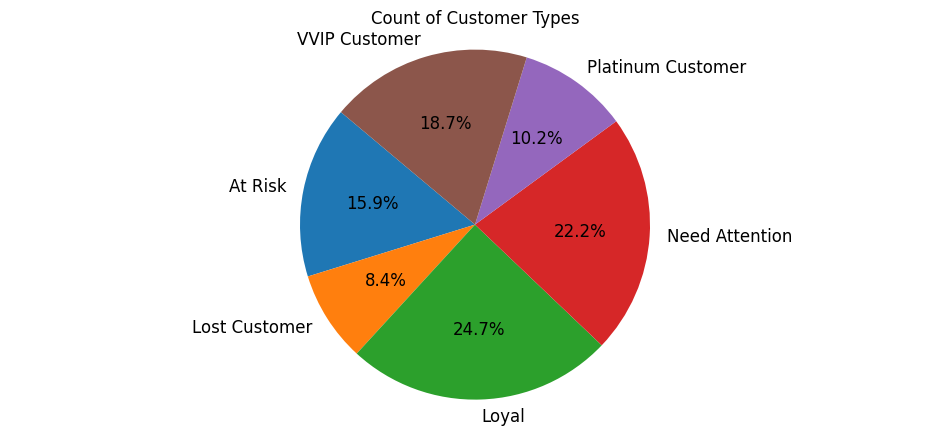

In [60]:
# Data
customer_types = ['At Risk', 'Lost Customer', 'Loyal', 'Need Attention', 'Platinum Customer', 'VVIP Customer']
counts = [477, 252, 741, 665, 305, 560]

# Create pie chart
plt.figure(figsize=(12, 5))
plt.pie(counts, labels=customer_types, autopct='%1.1f%%', startangle=140, colors=plt.cm.tab10.colors, textprops={'fontsize': 12})

# Add title
plt.title('Count of Customer Types')

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')

# Show the plot
plt.show()

# Part 4: Clustering and Customer Segmentation

Here, we have analyzed all files and engineered new features as per the need.

## 1. Lineitems table

### A. Aggregation based on total_spend, num_purchases

In [61]:
df_lineitems.columns

Index(['purchase_time', 'product_id', 'category', 'quantity', 'spend',
       'purchase_date'],
      dtype='object')

In [62]:
df_lineitems_agg = df_lineitems.groupby('customer_number').agg({'spend': 'sum', 'purchase_time': 'nunique'}).reset_index()
df_lineitems_agg.columns = ['customer_number', 'total_spend', 'num_of_unique_visits']
df_lineitems_agg.head(2)

,customer_number,total_spend,num_of_unique_visits
0,14,675.72,56
1,45,585.73,33


### B. Aggregation based on category

In [63]:
# Create a new dataframe of purchased quantities across product categories
lineitems_sample_quantity= df_lineitems.groupby(['customer_number','category'])['quantity'].sum().unstack('category', fill_value=0).add_prefix('QUANTITY_')
lineitems_sample_quantity.reset_index()

lineitems_sample_quantity.shape

(3000, 20)

In [64]:
veg_food_categories_quantity = ['QUANTITY_FRUIT_VEG', 'QUANTITY_DAIRY', 'QUANTITY_GROCERY_FOOD', 'QUANTITY_GROCERY_HEALTH_PETS']
other_food_categories_quantity = ['QUANTITY_BAKERY', 'QUANTITY_DISCOUNT_BAKERY', 'QUANTITY_DRINKS', 'QUANTITY_FROZEN', 'QUANTITY_DELI', 'QUANTITY_MEAT', 'QUANTITY_PREPARED_MEALS', 'QUANTITY_SOFT_DRINKS', 'QUANTITY_WORLD_FOODS']
miscellaneous_categories_quantity = ['QUANTITY_CASHPOINT', 'QUANTITY_CONFECTIONARY', 'QUANTITY_LOTTERY', 'QUANTITY_TOBACCO', 'QUANTITY_NEWSPAPERS_MAGAZINES', 'QUANTITY_PRACTICAL_ITEMS', 'QUANTITY_SEASONAL_GIFTING']

# Aggregate food category quantities
veg_food_category_quantities = lineitems_sample_quantity[veg_food_categories_quantity].sum(axis=1)
other_food_category_quantities = lineitems_sample_quantity[other_food_categories_quantity].sum(axis=1)
miscellaneous_category_quantities = lineitems_sample_quantity[miscellaneous_categories_quantity].sum(axis=1)

# Create DataFrame with aggregated category quantities
aggregated_category_quantities = pd.DataFrame({
    'veg_food_category_quantities': veg_food_category_quantities,
    'other_food_category_quantities': other_food_category_quantities,
    'miscellaneous_category_quantities': miscellaneous_category_quantities
})

# Display the head of the aggregated DataFrame
aggregated_category_quantities.head()

,veg_food_category_quantities,other_food_category_quantities,miscellaneous_category_quantities
customer_number,,,
14,252,245,34
45,343,145,167
52,73,199,22
61,210,191,98
63,103,101,77


In [65]:
# Create a new dataframe of purchased quantities across product categories
lineitems_sample_spend= df_lineitems.groupby(['customer_number','category'])['spend'].sum().unstack('category', fill_value=0).add_prefix('SPEND_')
lineitems_sample_spend.reset_index()

lineitems_sample_spend.shape

(3000, 20)

In [66]:
veg_food_categories_spend = ['SPEND_FRUIT_VEG', 'SPEND_DAIRY', 'SPEND_GROCERY_FOOD', 'SPEND_GROCERY_HEALTH_PETS']
other_food_categories_spend = ['SPEND_BAKERY', 'SPEND_DISCOUNT_BAKERY', 'SPEND_DRINKS', 'SPEND_FROZEN', 'SPEND_DELI', 'SPEND_MEAT', 'SPEND_PREPARED_MEALS', 'SPEND_SOFT_DRINKS', 'SPEND_WORLD_FOODS']
miscellaneous_categories_spend = ['SPEND_CASHPOINT', 'SPEND_CONFECTIONARY', 'SPEND_LOTTERY', 'SPEND_TOBACCO', 'SPEND_NEWSPAPERS_MAGAZINES', 'SPEND_PRACTICAL_ITEMS', 'SPEND_SEASONAL_GIFTING']

# Aggregate food category quantities
veg_food_category_spending = lineitems_sample_spend[veg_food_categories_spend].sum(axis=1)
other_food_category_spending = lineitems_sample_spend[other_food_categories_spend].sum(axis=1)
miscellaneous_category_spending = lineitems_sample_spend[miscellaneous_categories_spend].sum(axis=1)

# Create DataFrame with aggregated category quantities
aggregated_category_spend = pd.DataFrame({
    'veg_food_category_spend': veg_food_category_spending,
    'other_food_category_spend': other_food_category_spending,
    'miscellaneous_category_spend': miscellaneous_category_spending
})

# Display the head of the aggregated DataFrame
aggregated_category_spend.head()

,veg_food_category_spend,other_food_category_spend,miscellaneous_category_spend
customer_number,,,
14,251.01,390.02,34.69
45,280.10,181.60,124.03
52,71.67,109.90,40.61
61,227.36,256.66,63.85
63,102.74,112.53,78.07


#### Creating a merged_df

In [67]:
merged_df = df_lineitems_agg.merge(aggregated_category_quantities, on='customer_number')
merged_df = merged_df.merge(aggregated_category_spend, on='customer_number')
merged_df.set_index('customer_number', inplace=True)
merged_df.head()

,total_spend,num_of_unique_visits,veg_food_category_quantities,other_food_category_quantities,miscellaneous_category_quantities,veg_food_category_spend,other_food_category_spend,miscellaneous_category_spend
customer_number,,,,,,,,
14,675.72,56,252,245,34,251.01,390.02,34.69
45,585.73,33,343,145,167,280.10,181.60,124.03
52,222.18,59,73,199,22,71.67,109.90,40.61
61,547.87,37,210,191,98,227.36,256.66,63.85
63,293.34,48,103,101,77,102.74,112.53,78.07


## 2. Category Spends table

In [68]:
veg_food_categories = ['fruit_veg', 'dairy', 'grocery_food', 'grocery_health_pets']
other_food_categories = [ 'bakery', 'discount_bakery','prepared_meals', 'drinks', 'soft_drinks', 'frozen', 'meat', 'deli', 'world_foods']
miscellaneous_categories = ['confectionary', 'newspapers_magazines', 'tobacco', 'lottery', 'cashpoint', 'seasonal_gifting', 'practical_items']


# Aggregate food category spends
veg_food_category_spends = df_category_spends[veg_food_categories].sum(axis=1)
other_food_category_spends = df_category_spends[other_food_categories].sum(axis=1)
miscellaneous_category_spends = df_category_spends[miscellaneous_categories].sum(axis=1)

aggregated_category_spends = pd.DataFrame({
    'veg_food_category_spends': veg_food_category_spends,
    'other_food_category_spends': other_food_category_spends,
    'miscellaneous_category_spends': miscellaneous_category_spends
})

# Sort the DataFrame by the index column 'customer_number'
aggregated_category_spends_sorted = aggregated_category_spends.sort_index()

# Display the sorted DataFrame
aggregated_category_spends_sorted.head(3)


,veg_food_category_spends,other_food_category_spends,miscellaneous_category_spends
customer_number,,,
14,251.01,371.93,34.69
45,280.10,163.60,124.03
52,71.67,107.45,40.61


If we compare the aggregated_category_spends_sorted  with our merged_df from earlier, we can see that 'veg_food_category_spends' and 'miscellaneous_category_spends' are same. However, due to inconsistency in the bakery column in category_spends table, the values of other_food_categories (which included bakery category) are incorrect her. Thus, as we already have calculated the required values from lineitems table, we will not consider this table

In [69]:
merged_df.shape

(3000, 8)

## 3. Customer table

In [70]:
df_customer.head(2)

,baskets,total_quantity,average_quantity,total_spend,average_spend
customer_number,,,,,
4749,220,260,1.181818,631.12,2.87
4757,248,333,1.342742,452.42,1.82


#### Merging customers table with merged_df

In [71]:
merged_df = merged_df.merge(df_customer, on='customer_number')
merged_df.head()

,total_spend_x,num_of_unique_visits,veg_food_category_quantities,other_food_category_quantities,miscellaneous_category_quantities,veg_food_category_spend,other_food_category_spend,miscellaneous_category_spend,baskets,total_quantity,average_quantity,total_spend_y,average_spend
customer_number,,,,,,,,,,,,,
14,675.72,56,252,245,34,251.01,390.02,34.69,381,531,1.393701,675.72,1.77
45,585.73,33,343,145,167,280.10,181.60,124.03,561,655,1.167558,585.73,1.04
52,222.18,59,73,199,22,71.67,109.90,40.61,206,294,1.427184,222.18,1.08
61,547.87,37,210,191,98,227.36,256.66,63.85,420,499,1.188095,547.87,1.30
63,293.34,48,103,101,77,102.74,112.53,78.07,268,281,1.048507,293.34,1.09


In [72]:
merged_df.drop(columns = ['total_spend_y'], inplace = True)
merged_df.rename(columns={'total_spend_x':'total_spend'}, inplace = True)
merged_df.head(2)

,total_spend,num_of_unique_visits,veg_food_category_quantities,other_food_category_quantities,miscellaneous_category_quantities,veg_food_category_spend,other_food_category_spend,miscellaneous_category_spend,baskets,total_quantity,average_quantity,average_spend
customer_number,,,,,,,,,,,,
14,675.72,56,252,245,34,251.01,390.02,34.69,381,531,1.393701,1.77
45,585.73,33,343,145,167,280.10,181.60,124.03,561,655,1.167558,1.04


In [73]:
merged_df.rename(columns={'average_quantity':'average_basket_quantity','average_spend':'average_basket_spend'}, inplace = True)
merged_df.head(2)

,total_spend,num_of_unique_visits,veg_food_category_quantities,other_food_category_quantities,miscellaneous_category_quantities,veg_food_category_spend,other_food_category_spend,miscellaneous_category_spend,baskets,total_quantity,average_basket_quantity,average_basket_spend
customer_number,,,,,,,,,,,,
14,675.72,56,252,245,34,251.01,390.02,34.69,381,531,1.393701,1.77
45,585.73,33,343,145,167,280.10,181.60,124.03,561,655,1.167558,1.04


In [74]:
merged_df.shape

(3000, 12)

## 4. Baskets Table

In [75]:
df_baskets.head()

,purchase_time,basket_quantity,basket_spend,basket_categories
customer_number,,,,
11911,2007-03-01 07:06:00,7,3.09,3
4047,2007-03-01 07:13:00,9,7.99,5
3571,2007-03-01 07:27:00,9,37.06,6
4079,2007-03-01 07:34:00,11,11.91,5
6063,2007-03-01 07:36:00,3,1.45,1


In [76]:
baskets_sample_sum = df_baskets.groupby('customer_number')[['basket_quantity', 'basket_spend', 'basket_categories']].sum().add_prefix('SUM_')
baskets_sample_sum.head()

,SUM_basket_quantity,SUM_basket_spend,SUM_basket_categories
customer_number,,,
14,531,675.72,250
45,655,585.73,211
52,294,222.18,174
61,499,547.87,223
63,281,293.34,176


#### Since, SUM_basket_spend = total_spend, SUM_basket_quantity = total_quantity, we will drop these columns and only merge SUM_basket_categories

In [77]:
baskets_sample_sum.drop(columns = ['SUM_basket_quantity','SUM_basket_spend'], inplace = True)
baskets_sample_sum.head(2)

,SUM_basket_categories
customer_number,
14,250
45,211


In [78]:
merged_df = merged_df.merge(baskets_sample_sum, on='customer_number')
merged_df.head(2)

,total_spend,num_of_unique_visits,veg_food_category_quantities,other_food_category_quantities,miscellaneous_category_quantities,veg_food_category_spend,other_food_category_spend,miscellaneous_category_spend,baskets,total_quantity,average_basket_quantity,average_basket_spend,SUM_basket_categories
customer_number,,,,,,,,,,,,,
14,675.72,56,252,245,34,251.01,390.02,34.69,381,531,1.393701,1.77,250
45,585.73,33,343,145,167,280.10,181.60,124.03,561,655,1.167558,1.04,211


In [79]:
merged_df.isna().sum()

total_spend                          0
num_of_unique_visits                 0
veg_food_category_quantities         0
other_food_category_quantities       0
miscellaneous_category_quantities    0
veg_food_category_spend              0
other_food_category_spend            0
miscellaneous_category_spend         0
baskets                              0
total_quantity                       0
average_basket_quantity              0
average_basket_spend                 0
SUM_basket_categories                0
dtype: int64

There are no null values here.

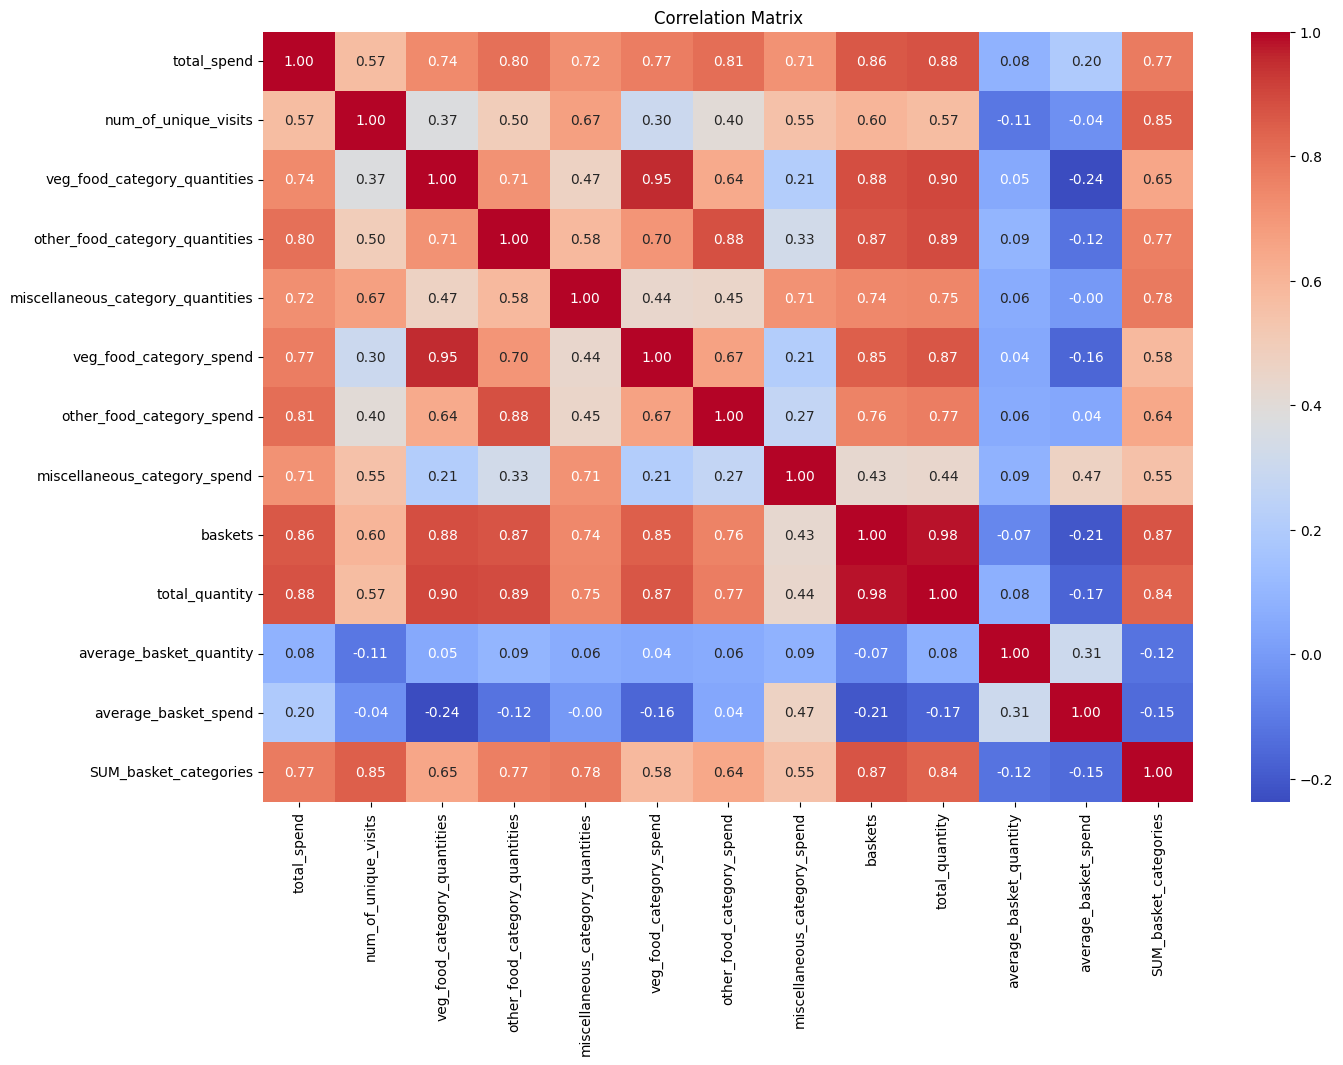

In [80]:
# Calculate the correlation matrix
corr_matrix = merged_df.corr(numeric_only = True)

# Set up the heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

Since there is a very high correlation between various category spends and quantities, we will aggregate them to get average spending per category.

In [81]:
merged_df.head()

,total_spend,num_of_unique_visits,veg_food_category_quantities,other_food_category_quantities,miscellaneous_category_quantities,veg_food_category_spend,other_food_category_spend,miscellaneous_category_spend,baskets,total_quantity,average_basket_quantity,average_basket_spend,SUM_basket_categories
customer_number,,,,,,,,,,,,,
14,675.72,56,252,245,34,251.01,390.02,34.69,381,531,1.393701,1.77,250
45,585.73,33,343,145,167,280.10,181.60,124.03,561,655,1.167558,1.04,211
52,222.18,59,73,199,22,71.67,109.90,40.61,206,294,1.427184,1.08,174
61,547.87,37,210,191,98,227.36,256.66,63.85,420,499,1.188095,1.30,223
63,293.34,48,103,101,77,102.74,112.53,78.07,268,281,1.048507,1.09,176


In [82]:
merged_df['avg_spend_veg_category'] = merged_df['veg_food_category_spend'] / merged_df['veg_food_category_quantities']
merged_df['avg_spend_other_food_category'] = merged_df['other_food_category_spend'] / merged_df['other_food_category_quantities']
merged_df['avg_spend_miscelleanous_category'] = merged_df['miscellaneous_category_spend'] / merged_df['miscellaneous_category_quantities']

merged_df.head(2)

,total_spend,num_of_unique_visits,veg_food_category_quantities,other_food_category_quantities,miscellaneous_category_quantities,veg_food_category_spend,other_food_category_spend,miscellaneous_category_spend,baskets,total_quantity,average_basket_quantity,average_basket_spend,SUM_basket_categories,avg_spend_veg_category,avg_spend_other_food_category,avg_spend_miscelleanous_category
customer_number,,,,,,,,,,,,,,,,
14,675.72,56,252,245,34,251.01,390.02,34.69,381,531,1.393701,1.77,250,0.996071,1.591918,1.020294
45,585.73,33,343,145,167,280.10,181.60,124.03,561,655,1.167558,1.04,211,0.816618,1.252414,0.742695


Even though baskets is among the important feature, since it is high correlated(0.98) with total quantity, we will drop it.

In [83]:
merged_df.drop(columns = ['veg_food_category_spend', 'veg_food_category_quantities','other_food_category_spend','other_food_category_quantities','miscellaneous_category_spend','miscellaneous_category_quantities'], inplace=True)
merged_df.drop(columns = ['baskets'], inplace = True)
merged_df.head()

,total_spend,num_of_unique_visits,total_quantity,average_basket_quantity,average_basket_spend,SUM_basket_categories,avg_spend_veg_category,avg_spend_other_food_category,avg_spend_miscelleanous_category
customer_number,,,,,,,,,
14,675.72,56,531,1.393701,1.77,250,0.996071,1.591918,1.020294
45,585.73,33,655,1.167558,1.04,211,0.816618,1.252414,0.742695
52,222.18,59,294,1.427184,1.08,174,0.981781,0.552261,1.845909
61,547.87,37,499,1.188095,1.30,223,1.082667,1.343770,0.651531
63,293.34,48,281,1.048507,1.09,176,0.997476,1.114158,1.013896


In [84]:
merged_df.shape

(3000, 9)

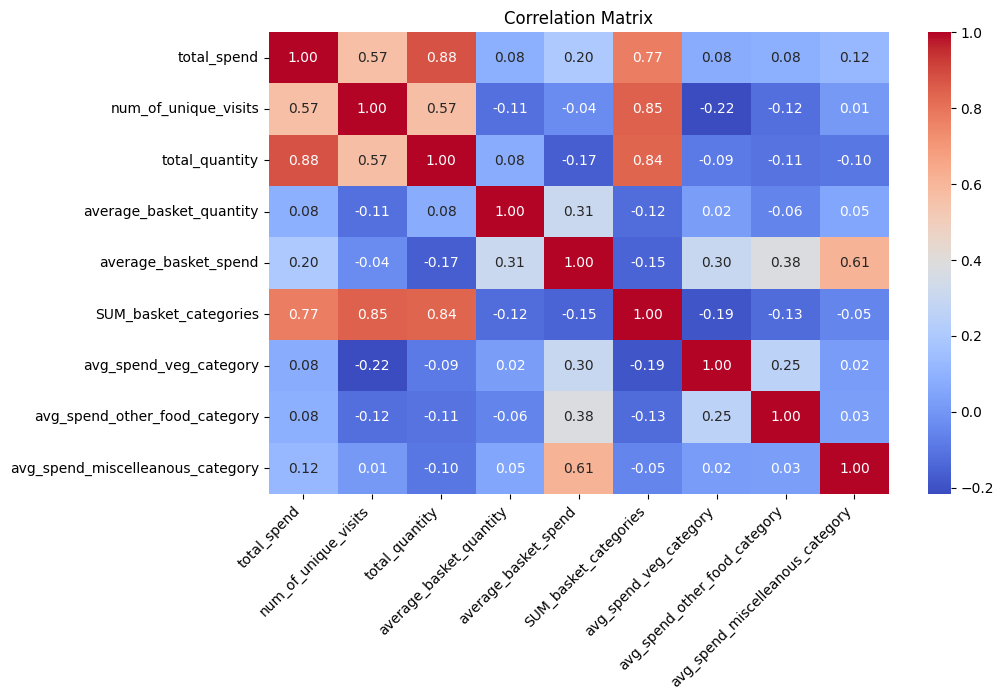

In [85]:
corr_matrix = merged_df.corr(numeric_only = True)

# Set up the heatmap
plt.figure(figsize=(10, 6))
heatmap = sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('Correlation Matrix')
plt.show()

In [86]:
customers_features_merged = merged_df

In [87]:
customers_features_merged.isna().sum()

total_spend                         0
num_of_unique_visits                0
total_quantity                      0
average_basket_quantity             0
average_basket_spend                0
SUM_basket_categories               0
avg_spend_veg_category              0
avg_spend_other_food_category       2
avg_spend_miscelleanous_category    1
dtype: int64

#### Filling the nan/null values

In [88]:
customers_features_merged['avg_spend_other_food_category'] = customers_features_merged['avg_spend_other_food_category'].fillna(method='ffill')
customers_features_merged['avg_spend_miscelleanous_category'] = customers_features_merged['avg_spend_miscelleanous_category'].fillna(method='ffill')

C:\Users\Prajakta\AppData\Local\Temp\ipykernel_3216\328866374.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  customers_features_merged['avg_spend_other_food_category'] = customers_features_merged['avg_spend_other_food_category'].fillna(method='ffill')
C:\Users\Prajakta\AppData\Local\Temp\ipykernel_3216\328866374.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  customers_features_merged['avg_spend_miscelleanous_category'] = customers_features_merged['avg_spend_miscelleanous_category'].fillna(method='ffill')


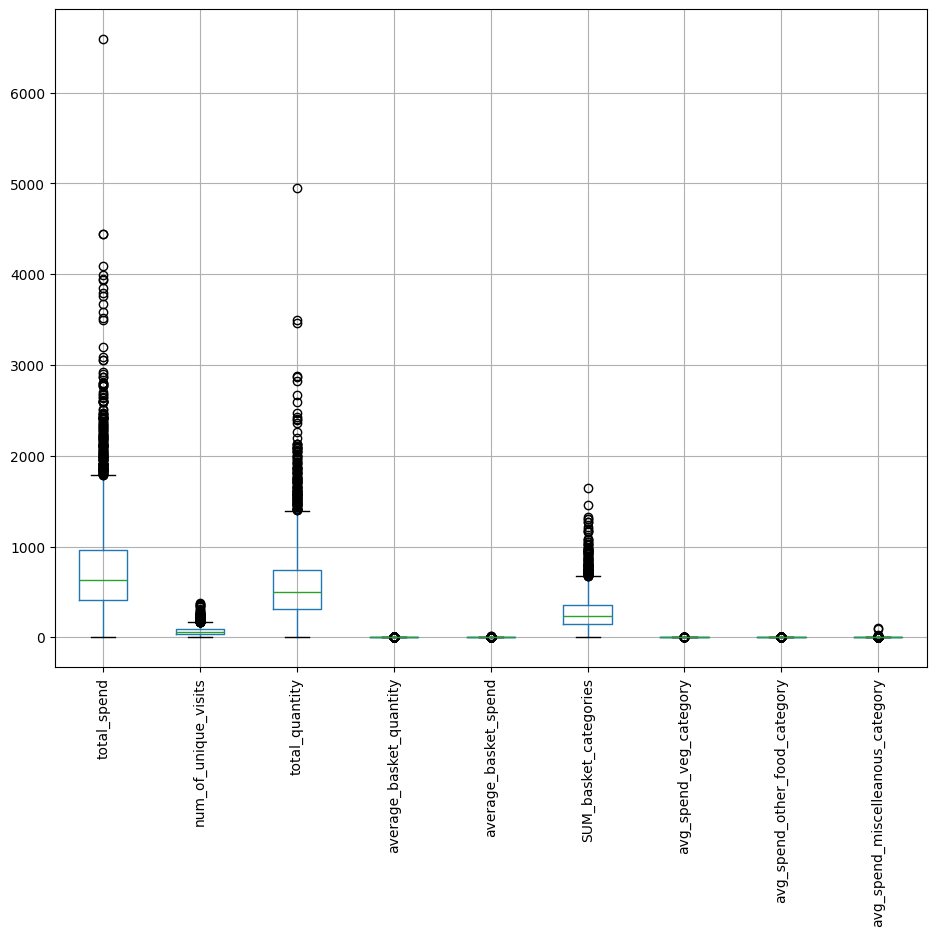

In [89]:
# Create a new figure with specified size
fig, ax = plt.subplots(figsize=(10.0, 10.0))

# Create a boxplot with default blue color
customers_features_merged.boxplot(ax=ax)

# Rotate the x-axis labels by 90 degrees
plt.xticks(rotation=90)

# Adjust layout
plt.tight_layout(pad=3.0, w_pad=0.5, h_pad=1.0)

# Show the plot
plt.show()

In [90]:
# Calculate the IQR for each feature
Q1 = customers_features_merged.quantile(0.25)
Q3 = customers_features_merged.quantile(0.75)
IQR = Q3 - Q1

# Determine outliers using IQR method
outliers = ((customers_features_merged < (Q1 - 1.5 * IQR)) | (customers_features_merged > (Q3 + 1.5 * IQR))).sum()

# Display the count of outliers for each feature
print("Number of outliers in each feature:")
print(outliers)

Number of outliers in each feature:
total_spend                         167
num_of_unique_visits                121
total_quantity                      130
average_basket_quantity             156
average_basket_spend                199
SUM_basket_categories               110
avg_spend_veg_category               53
avg_spend_other_food_category       143
avg_spend_miscelleanous_category    208
dtype: int64


#### Since we have a lot of outliers here, logging the data is used to mitigate the impact of outliers.

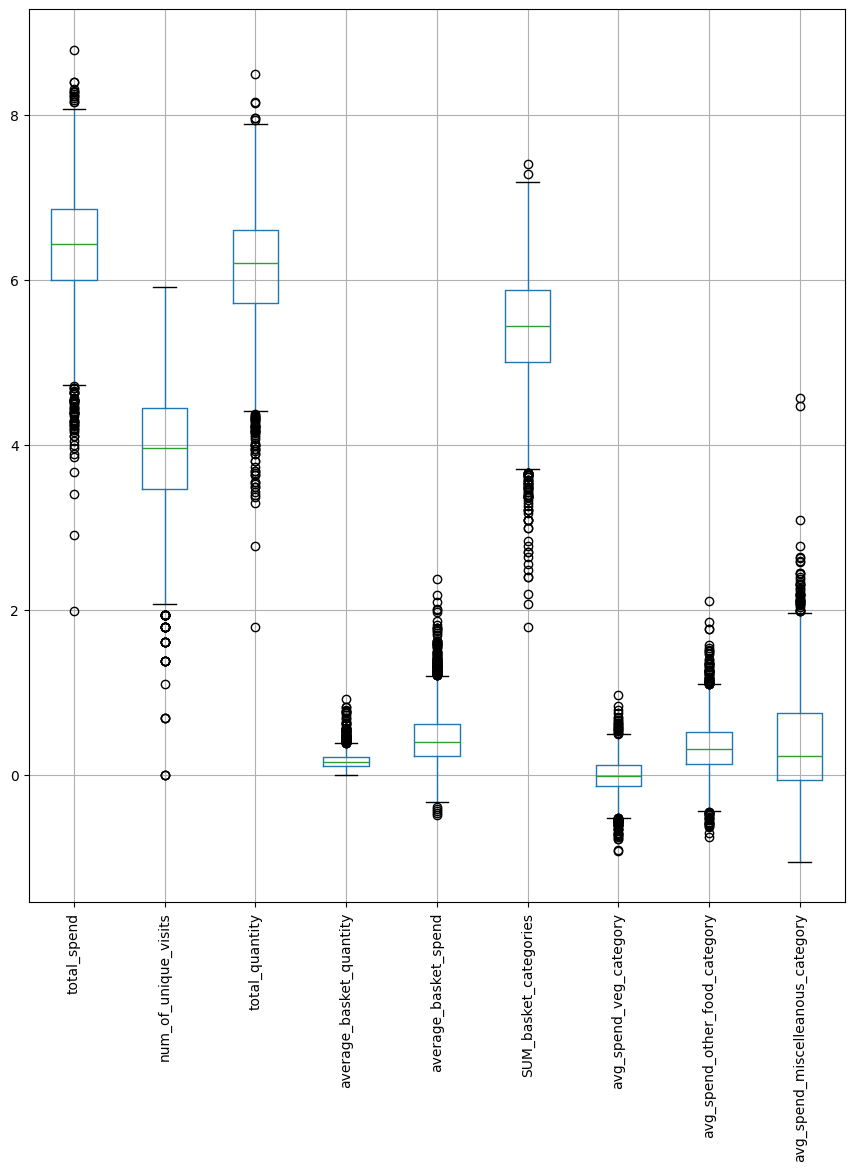

In [91]:
fig, ax = plt.subplots(figsize=(10.0, 10.0))

# Set the font size directly in the boxplot function call
np.log(customers_features_merged).boxplot(fontsize=10, ax=ax)

# Adjust layout
plt.tight_layout(pad=3.0, w_pad=0.5, h_pad=1.0)
plt.xticks(rotation=90)
# Show the plot
plt.show()

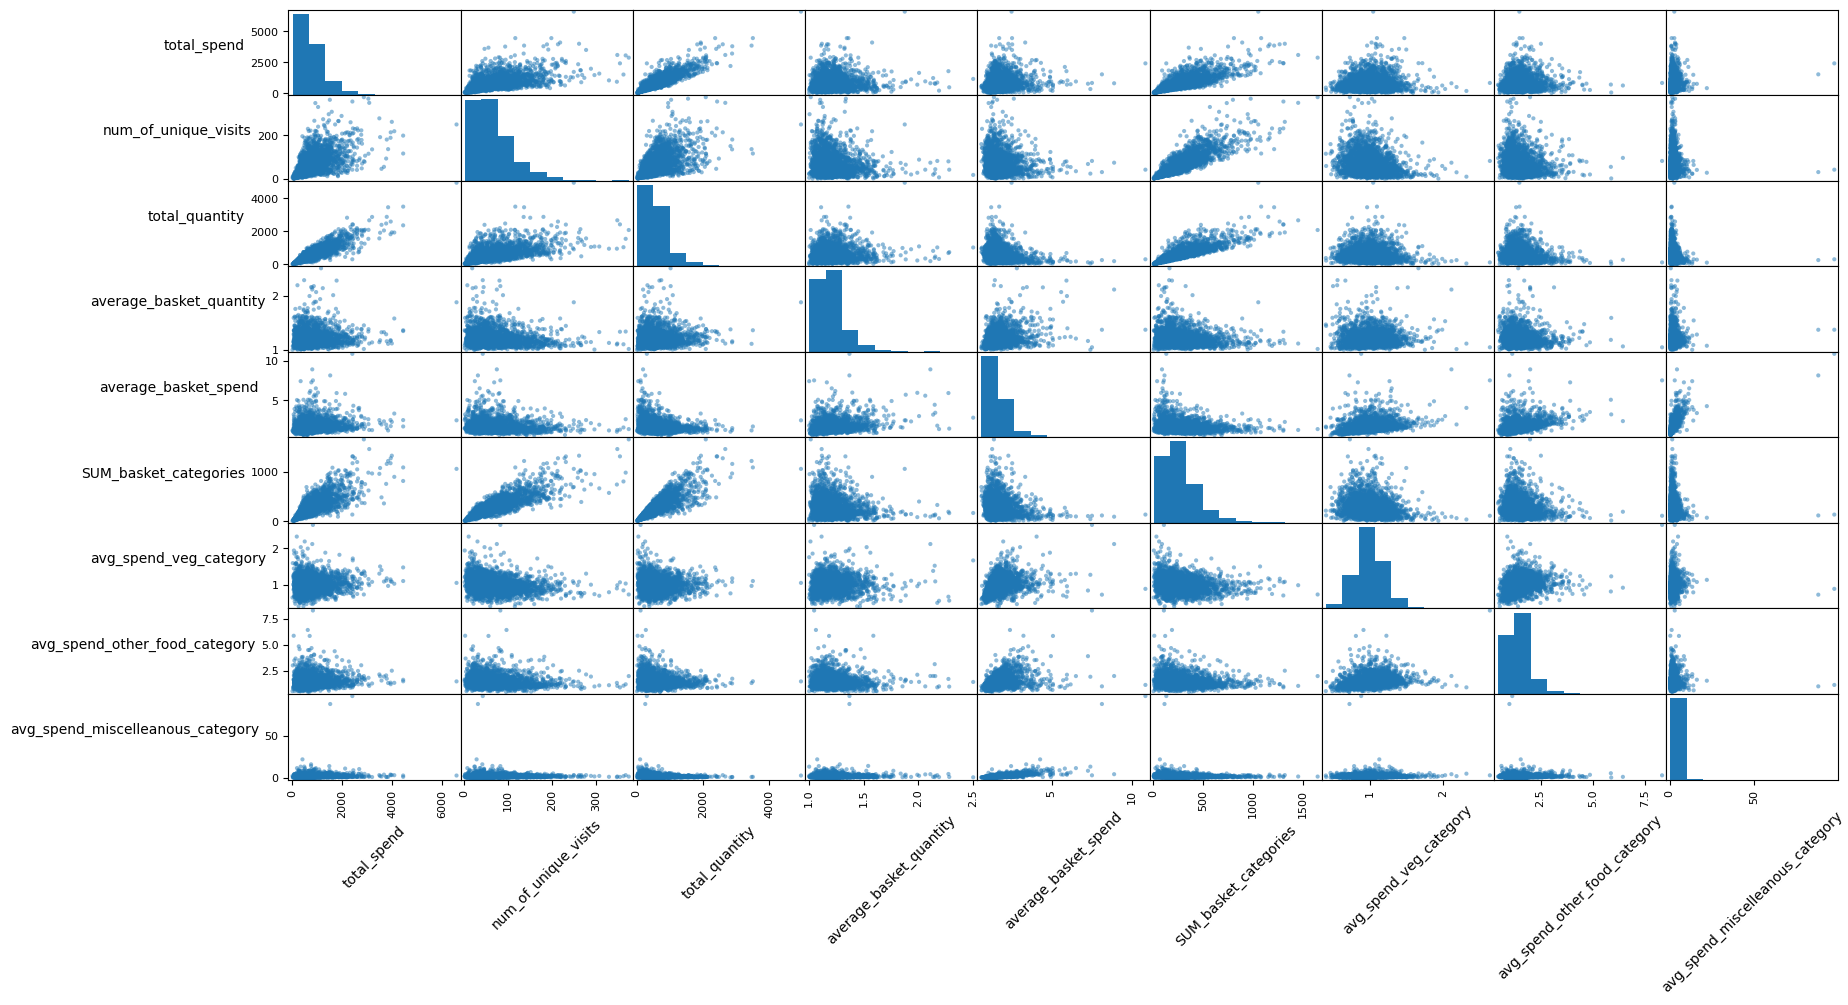

In [92]:
scatter = pd.plotting.scatter_matrix(customers_features_merged, figsize = (20,10))
for ax in scatter.flatten():
    ax.xaxis.label.set_rotation(45)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')  # Horizontal alignment

We can see that the data is not well distributed, thus, we will log-transform the data for distributing it properly.

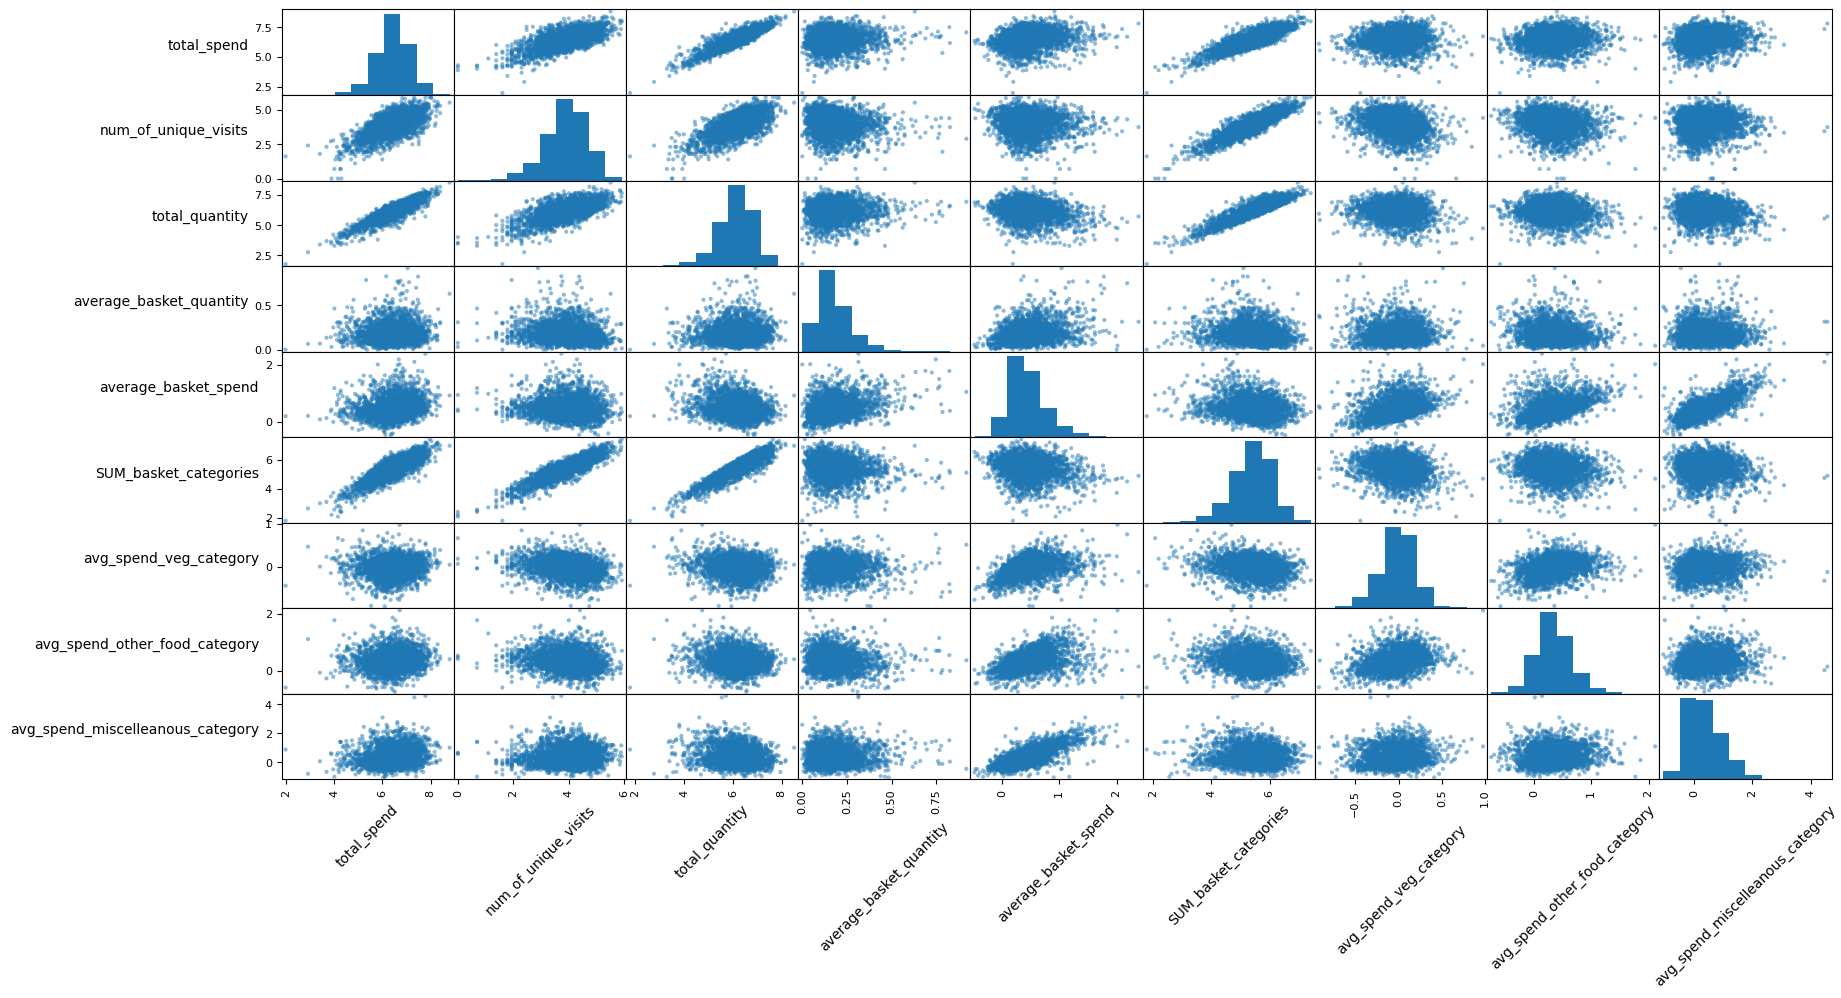

In [93]:
customers_features_merged = customers_features_merged.replace(0, 1)

for col in customers_features_merged.select_dtypes(include=['int64', 'float64']).columns:
    min_value = customers_features_merged[col].min()
    customers_features_merged[col] = np.where(customers_features_merged[col] < 0, 1, customers_features_merged[col])
# Scale the data using the natural logarithm
logged_data = np.log(customers_features_merged)

#-- Produce a scatter matrix using the logged data...
scatter = pd.plotting.scatter_matrix(logged_data, figsize = (20,10))
# Rotate x-axis labels by 45 degrees and keep y-axis labels horizontal
for ax in scatter.flatten():
    ax.xaxis.label.set_rotation(45)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')  # Horizontal alignment

Even after log-transform, there are still few features which are correlated to eachother, thus, further we will apply PCA to resolve this issue.

In [94]:
import sklearn

from sklearn.decomposition import PCA

#-- Apply PCA by fitting the good data with the same number of dimensions as features
pca = PCA(n_components=6)
pca.fit(logged_data)

PCA(n_components=6)

             total_spend  num_of_unique_visits  total_quantity  \
Dimension 1    -0.479783             -0.502288       -0.498585   
Dimension 2     0.220083              0.076990       -0.186224   
Dimension 3    -0.478455              0.687494       -0.389371   
Dimension 4     0.022603              0.313265       -0.266103   
Dimension 5     0.134699              0.185809       -0.084664   
Dimension 6     0.099930              0.127025        0.073247   

             average_basket_quantity  average_basket_spend  \
Dimension 1                 0.002793              0.021598   
Dimension 2                 0.014827              0.421174   
Dimension 3                -0.051273             -0.140378   
Dimension 4                -0.045493              0.243243   
Dimension 5                 0.169800              0.389014   
Dimension 6                 0.418252              0.444919   

             SUM_basket_categories  avg_spend_veg_category  \
Dimension 1              -0.516947      

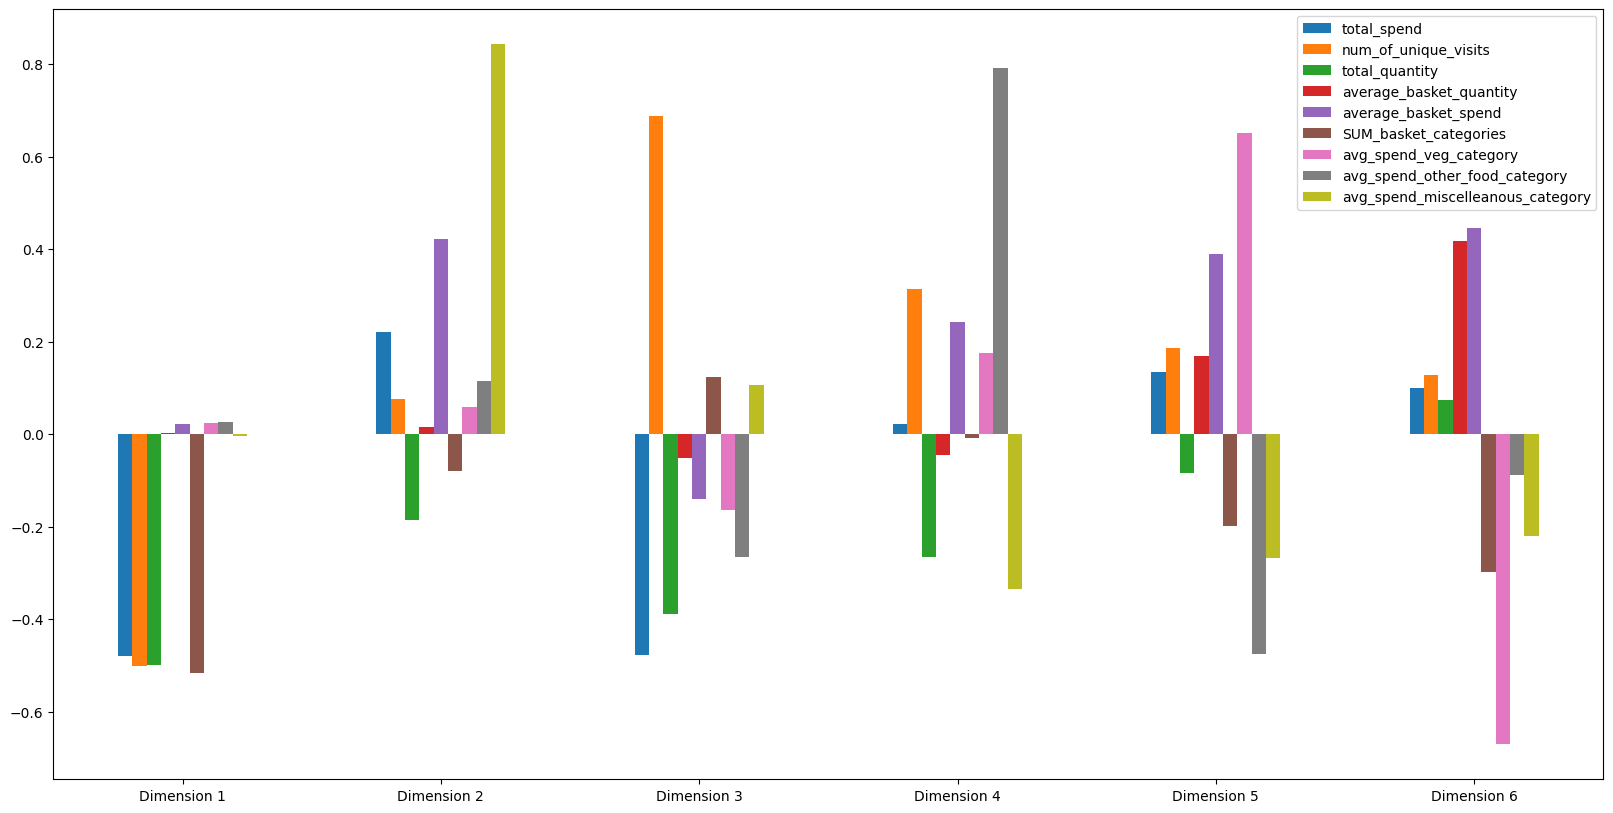

In [95]:
pca_results= pd.DataFrame(data= pca.fit(logged_data).components_, columns= customers_features_merged.columns, index= ['Dimension 1', 'Dimension 2', 'Dimension 3', 'Dimension 4', 'Dimension 5', 'Dimension 6'])
print(pca_results)

#-- Generate a PCA results bar plot
ax = pca_results.plot.bar(figsize=(20, 10))
ax.tick_params(axis='x', rotation=0)

#-- Print out the explained variance of each component, as well as cumulatively
explained_variance = pca.explained_variance_ratio_
print('Explained variance of each component:', explained_variance)
print('Cumulative explained variance:', np.cumsum(explained_variance))

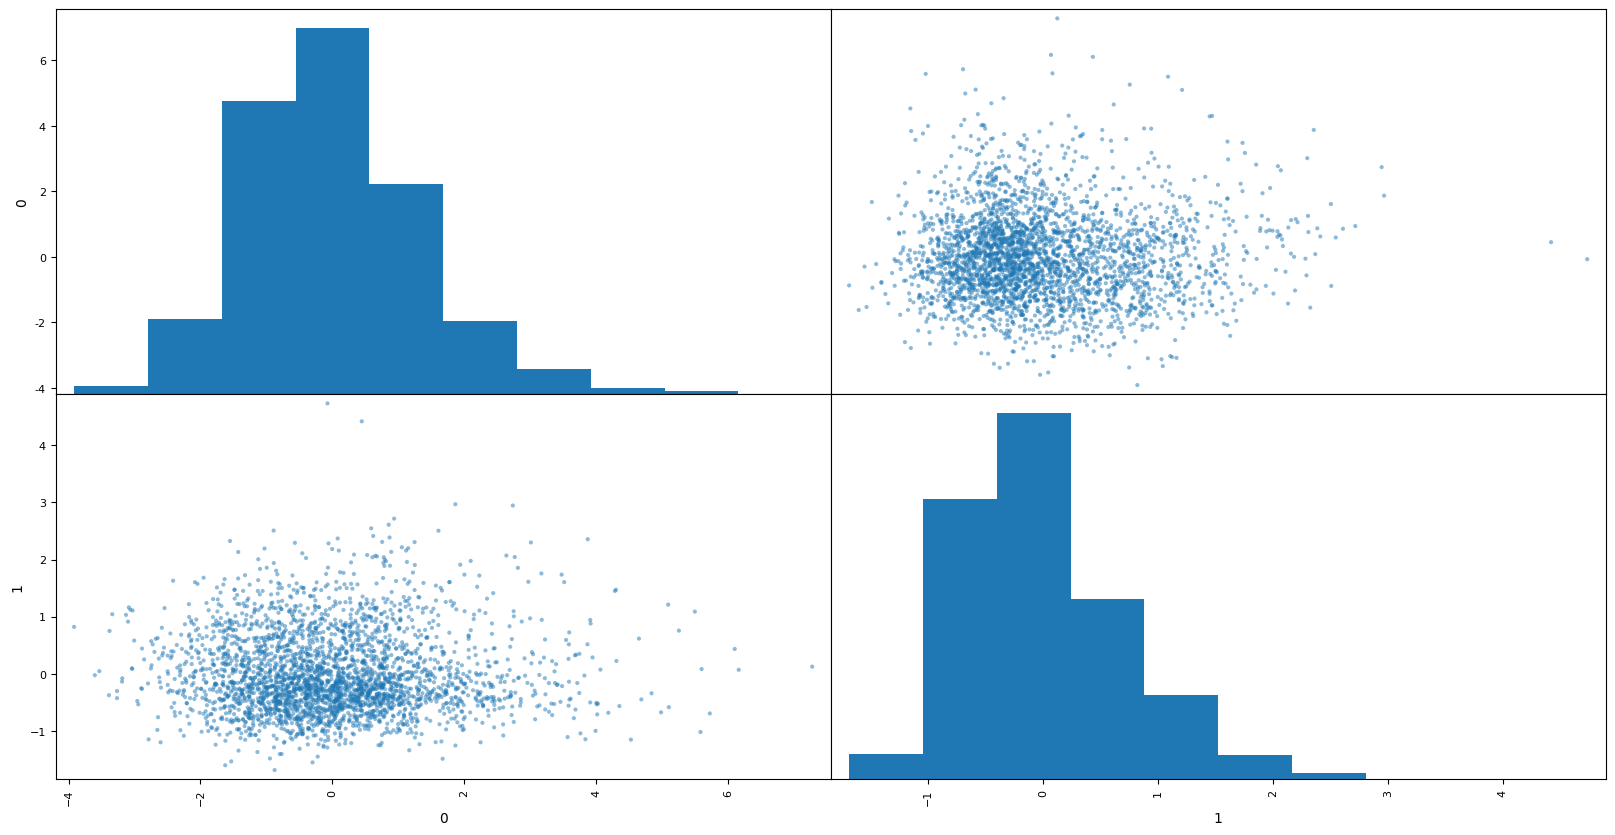

In [96]:
# TO DO: Apply PCA by fitting the good data with only two dimensions
# Instantiate
pca = PCA(n_components=2)
pca.fit(logged_data)

# TO DO: Transform the good data using the PCA fit above
reduced_data = pca.transform(logged_data)

# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data)
scatter = pd.plotting.scatter_matrix(reduced_data, figsize = (20,10))

In [97]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
# Create range of clusters
range_n_clusters = list(range(2, 11))
silhouette_scores = []
print(range_n_clusters)

# Loop through clusters
for n_clusters in range_n_clusters:
    # TO DO: Apply your clustering algorithm of choice to the reduced data
    clusterer = KMeans(n_clusters = n_clusters).fit(reduced_data)

    # TO DO: Predict the cluster for each data point
    preds = clusterer.predict(reduced_data)

    # TO DO: Find the cluster centers
    centers = clusterer.cluster_centers_

    # TO DO: Calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(reduced_data, preds, metric='euclidean')
    silhouette_scores.append(score)
    print("For n_clusters = {}. The average silhouette_score is : {})".format(n_clusters, score))

[2, 3, 4, 5, 6, 7, 8, 9, 10]
For n_clusters = 2. The average silhouette_score is : 0.4135455925929403)


C:\Users\Prajakta\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Prajakta\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 3. The average silhouette_score is : 0.36053808920216884)
For n_clusters = 4. The average silhouette_score is : 0.3731316549143333)


C:\Users\Prajakta\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Prajakta\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 5. The average silhouette_score is : 0.35502056568244506)
For n_clusters = 6. The average silhouette_score is : 0.35837046717351645)


C:\Users\Prajakta\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Prajakta\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 7. The average silhouette_score is : 0.34994347802382875)
For n_clusters = 8. The average silhouette_score is : 0.3348381645584669)


C:\Users\Prajakta\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Prajakta\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 9. The average silhouette_score is : 0.33377189910870086)
For n_clusters = 10. The average silhouette_score is : 0.3345749286586876)


C:\Users\Prajakta\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


C:\Users\Prajakta\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Prajakta\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Prajakta\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Prajakta\AppData\Local\Programs\Python\Python311\Lib\site-packages\

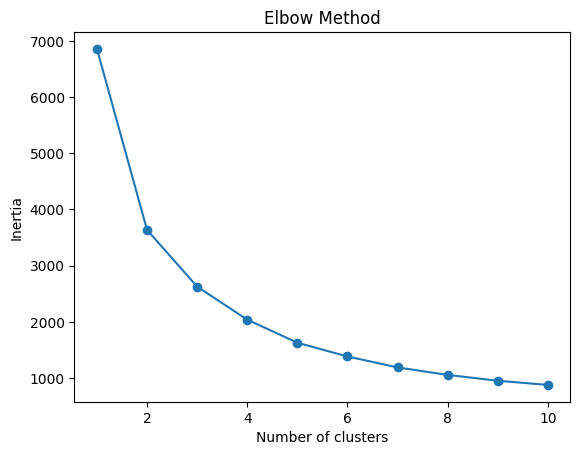

In [98]:
inertia = []
for n_clusters in range(1, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(reduced_data)
    inertia.append(kmeans.inertia_)

# Plotting the elbow curve
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

C:\Users\Prajakta\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


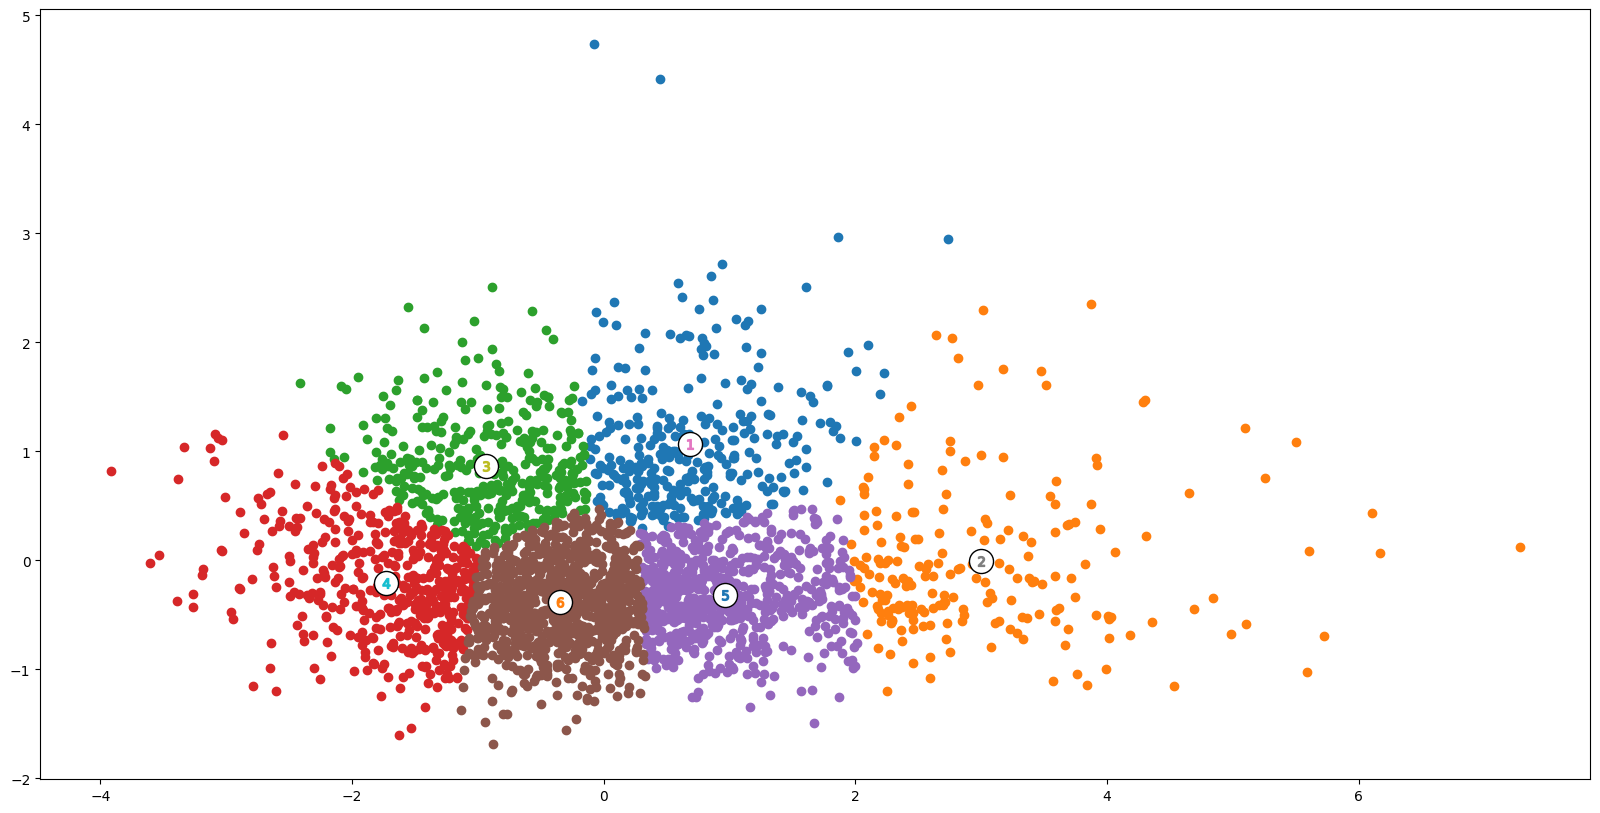

In [99]:
import random

# Set a fixed random seed
random_seed = 42 
np.random.seed(random_seed)
random.seed(random_seed)

#-- Our final clustering solution
clusterer = KMeans(n_clusters=6).fit(reduced_data)
preds = clusterer.predict(reduced_data)
centres = clusterer.cluster_centers_

# Add 1 to cluster labels to start numbering from 1
preds += 1

#-- Put the predictions into a pandas dataframe format
assignments = pd.DataFrame(preds, columns = ['Cluster'])

#-- Put the predictions into a pandas dataframe format
plot_data = pd.concat([assignments, reduced_data], axis = 1)

#-- Color the points based on assigned cluster (n.b scatter will do this for us automatically)
plt.rcParams['figure.figsize'] = (20,10)

for i, c in plot_data.groupby('Cluster'):
    plt.scatter(c[0], c[1])

#-- Plot where the cluster centers are
for i, c in enumerate(centres):
    plt.scatter(x = c[0], y = c[1], color = 'white', edgecolors = 'black', marker = 'o', s=300);
    plt.scatter(x = c[0], y = c[1], marker='${}$'.format(i+1), alpha = 1, s=50);

In [100]:
# TO DO: Inverse transform the centres
log_centres = pca.inverse_transform(centres)

# TO DO: Exponentiate the centres
true_centres = np.exp(log_centres)

#-- Display the true centres
segments = ['Segment {}'.format(i+1) for i in range(0, len(centres))]
true_centres = pd.DataFrame(np.round(true_centres), columns = customers_features_merged.columns)
true_centres.index = segments
true_centres

,total_spend,num_of_unique_visits,total_quantity,average_basket_quantity,average_basket_spend,SUM_basket_categories,avg_spend_veg_category,avg_spend_other_food_category,avg_spend_miscelleanous_category
Segment 1,558.0,39.0,271.0,1.0,3.0,143.0,1.0,2.0,4.0
Segment 2,145.0,11.0,104.0,1.0,2.0,47.0,1.0,2.0,1.0
Segment 3,1161.0,86.0,631.0,1.0,2.0,335.0,1.0,2.0,3.0
Segment 4,1341.0,118.0,1143.0,1.0,1.0,551.0,1.0,1.0,1.0
Segment 5,360.0,30.0,305.0,1.0,1.0,138.0,1.0,1.0,1.0
Segment 6,664.0,58.0,593.0,1.0,1.0,273.0,1.0,1.0,1.0


In [101]:
customers_features_merged.reset_index(inplace=True)

In [102]:
#-- Join the segment assignments to the original data
final_assigments = pd.concat([assignments, customers_features_merged], axis = 1)

#-- Create a loop that describes summary statistics for each segment
for c, d in final_assigments.groupby('Cluster'):
    print("Segment", c)
    display(d.describe())

Segment 1


,Cluster,customer_number,total_spend,num_of_unique_visits,total_quantity,average_basket_quantity,average_basket_spend,SUM_basket_categories,avg_spend_veg_category,avg_spend_other_food_category,avg_spend_miscelleanous_category
count,321.0,321.000000,321.000000,321.000000,321.000000,321.000000,321.000000,321.000000,321.000000,321.000000,321.000000
mean,1.0,9508.853583,570.032118,44.031153,284.314642,1.242292,2.680000,150.286604,1.051595,1.690984,4.579136
std,0.0,4571.462284,227.324078,17.529947,108.190388,0.180075,1.225039,42.591212,0.261862,0.818454,7.398396
min,1.0,111.000000,238.940000,12.000000,45.000000,1.000000,1.060000,41.000000,0.495000,0.602609,1.061818
25%,1.0,5702.000000,420.200000,31.000000,209.000000,1.126027,1.930000,118.000000,0.880000,1.185155,2.569891
50%,1.0,10114.000000,531.220000,42.000000,278.000000,1.195335,2.340000,148.000000,1.040577,1.499302,3.301607
75%,1.0,13454.000000,676.600000,54.000000,345.000000,1.306620,2.990000,182.000000,1.172872,1.969759,4.427069
max,1.0,16306.000000,2407.450000,104.000000,1006.000000,2.155963,10.840000,250.000000,2.646667,8.302637,97.200909


Segment 2


,Cluster,customer_number,total_spend,num_of_unique_visits,total_quantity,average_basket_quantity,average_basket_spend,SUM_basket_categories,avg_spend_veg_category,avg_spend_other_food_category,avg_spend_miscelleanous_category
count,214.0,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,2.0,10139.457944,162.574533,13.116822,118.920561,1.215757,1.778925,51.971963,1.086218,1.639919,1.776172
std,0.0,5134.378790,72.546747,7.203312,56.330666,0.148265,0.715225,19.775718,0.258742,0.696438,1.522833
min,2.0,149.000000,7.280000,1.000000,6.000000,1.000000,0.920000,6.000000,0.472143,0.550000,0.367143
25%,2.0,5332.250000,109.877500,8.000000,76.250000,1.119881,1.340000,37.250000,0.924801,1.204882,0.958846
50%,2.0,12175.500000,156.205000,12.000000,115.000000,1.178629,1.590000,53.500000,1.058996,1.514000,1.230667
75%,2.0,14399.000000,207.415000,17.000000,153.000000,1.282179,1.930000,67.750000,1.219871,1.887988,1.859643
max,2.0,16229.000000,422.180000,50.000000,333.000000,2.190476,5.050000,99.000000,2.325333,5.875000,11.510714


Segment 3


,Cluster,customer_number,total_spend,num_of_unique_visits,total_quantity,average_basket_quantity,average_basket_spend,SUM_basket_categories,avg_spend_veg_category,avg_spend_other_food_category,avg_spend_miscelleanous_category
count,376.0,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000
mean,3.0,8362.534574,1214.751064,93.619681,657.763298,1.213801,2.291011,350.638298,1.016315,1.586652,3.290934
std,0.0,3814.430658,465.032129,34.505366,225.237569,0.149875,0.700696,98.542536,0.205035,0.604772,1.460401
min,3.0,498.000000,445.750000,26.000000,272.000000,1.012346,1.190000,170.000000,0.398735,0.556837,1.488919
25%,3.0,5319.750000,872.620000,69.000000,486.500000,1.122171,1.817500,275.000000,0.892326,1.188796,2.403074
50%,3.0,8146.500000,1083.615000,89.000000,621.000000,1.183557,2.160000,338.500000,1.012985,1.464167,2.861944
75%,3.0,11068.250000,1439.942500,112.000000,777.750000,1.256838,2.530000,411.000000,1.143590,1.860713,3.721940
max,3.0,16203.000000,3676.460000,266.000000,2052.000000,2.276667,5.920000,738.000000,1.881053,4.498696,13.929143


Segment 4


,Cluster,customer_number,total_spend,num_of_unique_visits,total_quantity,average_basket_quantity,average_basket_spend,SUM_basket_categories,avg_spend_veg_category,avg_spend_other_food_category,avg_spend_miscelleanous_category
count,484.0,484.000000,484.000000,484.000000,484.000000,484.000000,484.000000,484.000000,484.000000,484.000000,484.000000
mean,4.0,7274.411157,1473.924401,130.962810,1212.107438,1.193189,1.446281,576.382231,0.955827,1.382149,1.343164
std,0.0,3995.556239,702.622502,57.349232,478.941207,0.113744,0.362316,198.296024,0.177790,0.457943,0.602104
min,4.0,156.000000,543.810000,30.000000,588.000000,1.003717,0.620000,293.000000,0.463117,0.497511,0.376879
25%,4.0,3957.000000,970.540000,89.000000,889.750000,1.116211,1.207500,443.000000,0.824010,1.089877,0.903960
50%,4.0,7234.500000,1311.425000,122.500000,1074.000000,1.171416,1.410000,520.000000,0.964383,1.278790,1.197343
75%,4.0,10575.000000,1775.902500,161.000000,1411.750000,1.244601,1.620000,655.000000,1.059060,1.582463,1.656666
max,4.0,16292.000000,6588.650000,374.000000,4949.000000,1.876042,3.350000,1650.000000,1.501315,4.388016,3.901168


Segment 5


,Cluster,customer_number,total_spend,num_of_unique_visits,total_quantity,average_basket_quantity,average_basket_spend,SUM_basket_categories,avg_spend_veg_category,avg_spend_other_food_category,avg_spend_miscelleanous_category
count,675.0,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000
mean,5.0,7984.582222,384.928044,32.422222,323.791111,1.198499,1.441496,143.253333,1.020748,1.472001,1.165851
std,0.0,5126.927536,129.202340,13.655070,102.301291,0.115298,0.314904,35.815130,0.195700,0.461719,0.389505
min,5.0,52.000000,115.900000,8.000000,132.000000,1.013807,0.740000,56.000000,0.402889,0.552261,0.350435
25%,5.0,3048.000000,290.665000,22.500000,247.500000,1.120087,1.245000,115.500000,0.897902,1.175196,0.896310
50%,5.0,7840.000000,370.140000,30.000000,312.000000,1.176471,1.400000,146.000000,1.010405,1.397132,1.080991
75%,5.0,12682.000000,455.655000,41.000000,386.000000,1.243603,1.590000,169.500000,1.141511,1.690246,1.386250
max,5.0,16316.000000,928.010000,100.000000,726.000000,2.150838,4.450000,245.000000,1.918846,3.850326,2.604375


Segment 6


,Cluster,customer_number,total_spend,num_of_unique_visits,total_quantity,average_basket_quantity,average_basket_spend,SUM_basket_categories,avg_spend_veg_category,avg_spend_other_food_category,avg_spend_miscelleanous_category
count,930.0,930.000000,930.000000,930.000000,930.000000,930.000000,930.000000,930.000000,930.000000,930.000000,930.000000
mean,6.0,7537.920430,710.231516,62.509677,625.713978,1.195343,1.367774,280.305376,0.978856,1.409176,1.106498
std,0.0,4696.309416,250.937049,26.107058,194.659759,0.132702,0.310035,67.345080,0.186421,0.453762,0.381516
min,6.0,14.000000,294.380000,12.000000,260.000000,1.006849,0.630000,115.000000,0.484883,0.472640,0.364789
25%,6.0,3119.250000,540.530000,43.000000,491.000000,1.114770,1.160000,227.250000,0.852007,1.128429,0.833068
50%,6.0,7574.000000,657.290000,58.000000,594.000000,1.172295,1.340000,269.500000,0.975343,1.343071,1.038016
75%,6.0,11406.000000,819.382500,79.000000,721.000000,1.240250,1.520000,324.000000,1.095708,1.605153,1.301559
max,6.0,16287.000000,2211.590000,195.000000,1600.000000,2.503686,3.210000,502.000000,1.667630,6.431515,2.526500


In [103]:
for c, d in final_assigments.groupby('Cluster'):
    segment_filename = f"segment_{c}.csv"  # Define the filename for each segment
    d.to_csv(segment_filename, index=False)  # Save the segment DataFrame to a CSV file
    print(f"Segment {c} saved to {segment_filename}")

Segment 1 saved to segment_1.csv
Segment 2 saved to segment_2.csv
Segment 3 saved to segment_3.csv
Segment 4 saved to segment_4.csv
Segment 5 saved to segment_5.csv
Segment 6 saved to segment_6.csv


In [104]:
# List of segment CSV files
segment_files = ['segment_1.csv', 'segment_2.csv', 'segment_3.csv', 'segment_4.csv', 'segment_5.csv', 'segment_6.csv']

# Read each segment CSV file into a DataFrame and store them in a list
segment_dfs = []
for file in segment_files:
    segment_df = pd.read_csv(file)
    segment_dfs.append(segment_df)

# Concatenate all segment DataFrames vertically
customer_segments = pd.concat(segment_dfs, ignore_index=True)

# Write the combined DataFrame to a new CSV file
customer_segments.to_csv('customer_segments_combined.csv', index=False)